In [1]:
import sys
print(sys.version_info)
assert sys.version_info >= (3, 7)

from packaging import version
import sklearn
print ("Scikit-Learn version: ", sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

sys.version_info(major=3, minor=11, micro=4, releaselevel='final', serial=0)
Scikit-Learn version:  1.3.0


here we're trying to get the wrong labeled data (like "=" is labeled to "+")
BUT it is impossible to check all 17000 img and check them(we can, but... really?)
or we can use the model to identify them

how? by using well-trained model! we have Mnist!
so the plan is;
1. train the mnist that has a good score(like 0.97 or 98)
2. for each img check the score using our mnist model. If the score is quite low(to a certain threshold, we may assume that is it mislabeled
3. check the img and label, and fix

this may minimize our man-work

In [2]:
from pathlib import Path

path = Path() / "npz" / "asdf"
print(path)

npz\asdf


## dataset preparation

In [3]:
from sklearn.datasets import fetch_openml

openml = fetch_openml('mnist_784', as_frame=False, parser="auto")
mnist = openml

# get the latest datasets
curr_data_num_trVal = np.load(path / "digit_data_TrVal_corrected.npz")
curr_data_sym_trVal = np.load(path / "op_data_TrVal_corrected.npz")

curr_data_num_test = np.load(path / "digit_data_10_Test_corrected.npz")
curr_data_sym_test = np.load(path / "op_data_10_Test_corrected.npz")

## prepare models

currently, our strongest model so far is the assemble model, with 0.97 score

### mnist

In [4]:
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# 
# voting_clf = VotingClassifier(
#     estimators=[
#         ('lr', LogisticRegression(random_state=42)),
#         ('rf', RandomForestClassifier(random_state=42)),
#         ('svc', SVC(random_state=42))
#     ]
# ,voting="soft",n_jobs=-1)
# X_train, y_train = mnist.data, mnist.target
# voting_clf.fit(X_train, y_train)

In [5]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import RobustScaler
# 
# random = 42
# 
# # StandardScaler 사용
# nn_clf_mnist = make_pipeline(StandardScaler(), MLPClassifier(random_state=random,solver="lbfgs",max_iter=300))
# X_train, y_train = mnist.data / 255, mnist.target
# nn_clf_mnist.fit(X_train, y_train)

In [6]:
# from sklearn.model_selection import cross_val_score
# 
# cross_val_score(nn_clf_mnist, X_train, y_train, cv=5)

### our data

In [7]:
def rebase_center(img):
    r = 28
    c = 28

    # each boundary
    r_top = r
    r_bot = -1
    c_left = c
    c_right = -1

    for n in range(r):
        for m in range(c):
            
            # if the pixel has whatever value
            if img[n][m] != 0:
                # update the boundary
                r_top = min(r_top, n)
                r_bot = max(r_bot, n)
                c_left = min(c_left, m)
                c_right = max(c_right, m)
    
    # print(r_top,r_bot,c_left,c_right)
    
    c_len = c_right - c_left + 1
    r_len = r_bot - r_top + 1

    c_start = int((c - c_len) / 2)
    r_start = int((r - r_len) / 2)

    # print(c_len,r_len,c_start,r_start)

    rebased_data = np.zeros((r,c),dtype="float64")

    # rebase into a center
    rebased_data[r_start:r_start+r_len, c_start:c_start+c_len] = img[r_top:r_bot+1, c_left:c_right+1]
    
    return rebased_data


In [8]:
def detect_del_boundary(img, thickness=4, thres=10):
    cur = np.reshape(img, (28, 28))

    # how much you want to look at
    t = thickness
    # the threshold
    threshold_t = thres

    cnt_top = np.count_nonzero(cur[0:t, :])
    cnt_down = np.count_nonzero(cur[28 - t:28, :])
    cnt_left = np.count_nonzero(cur[:, 0:t])
    cnt_right = np.count_nonzero(cur[:, 28 - t:28])

    flag = False

    if cnt_top > threshold_t:
        cur[0:t, :] = 0.
        flag = True

    if cnt_down > threshold_t:
        cur[28 - t:28, :] = 0.
        flag = True

    if cnt_left > threshold_t:
        cur[:, 0:t] = 0.
        flag = True

    if cnt_right > threshold_t:
        cur[:, 28 - t:28] = 0.
        flag = True

    return rebase_center(cur) if flag is True else cur


In [9]:
def preprocessing(img, rebase=True, b_del=True, thick=True, one_array=True):    
    siz = np.shape(img)[0]
    
    # row and column length
    r = 28
    c = 28
    
    # reshape to 2-d array(for convenience)
    img_preprocessed = np.reshape(img, (siz, r, c))
    
    # rebase
    if rebase:
        print("rebase ongoing")
        
        for x in range(siz):
            img_preprocessed[x] = rebase_center(img_preprocessed[x])
        print("done!")
    
    # border deletion
    if b_del:
        print("border deletion ongoing")
        
        for x in range(siz):
            img_preprocessed[x] = detect_del_boundary(img_preprocessed[x])
            
        print("done!")
    
    # thickening
    if thick:
        print("thickening ongoing")
        
        print("done!")
    
    return np.reshape(img_preprocessed, (siz, r * c)) if one_array else np.reshape(img_preprocessed, (siz, r, c))


In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

random = 42

# RobustScaler 사용
nn_clf_ours = make_pipeline(RobustScaler(), MLPClassifier(random_state=random,solver="lbfgs",max_iter=300))
X_train_ours, y_train_ours = preprocessing(curr_data_num_trVal["img"].copy()), curr_data_num_trVal["label"].copy()

nn_clf_ours.fit(X_train_ours, y_train_ours)

rebase ongoing
done!
border deletion ongoing
done!
thickening ongoing
done!


Pipeline(steps=[('robustscaler', RobustScaler()),
                ('mlpclassifier',
                 MLPClassifier(max_iter=300, random_state=42, solver='lbfgs'))])

In [11]:
# cross_val_score(nn_clf_ours, X_train_ours, y_train_ours, cv=5)

so now we have 2 models, mnist and ours with 0.97, 0.75 score

### find mislabel - test

In [12]:
size = np.shape(X_train_ours)[0]

list_mnist = []
list_mnist_score = []
list_ours = []
list_ours_score = []

for i in range(size):
    curr = np.reshape(X_train_ours[i].copy(), (1,-1))
    label = curr_data_num_trVal["label"][i]

    # predict_mnist = nn_clf_mnist.predict(curr)
    predict_ours = nn_clf_ours.predict(curr)

    # score_mnist = nn_clf_mnist.predict_proba(curr)
    # score_ours = nn_clf_ours.predict_proba(curr)
    
    # if predict_mnist != label:
    #     list_mnist = np.append(list_mnist, i)
    #     list_mnist_score = np.append(list_mnist_score, nn_clf_mnist.predict_proba(curr))

    if predict_ours != label:
        list_ours = np.append(list_ours, i)
        list_ours_score = np.append(list_ours_score, nn_clf_ours.predict_proba(curr))
    

In [13]:
print(len(list_ours),len(list_mnist))

7 0


so mnist is not that efficient finding mislabeled ones(which is worried about later work)
let's check the wrong labeled ones

In [14]:
import matplotlib.pyplot as plt

def plot_digit(image_data, axis=False):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")

    if not axis:
        plt.axis("off")

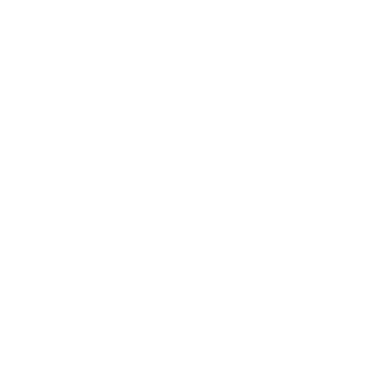

index: 1448
9


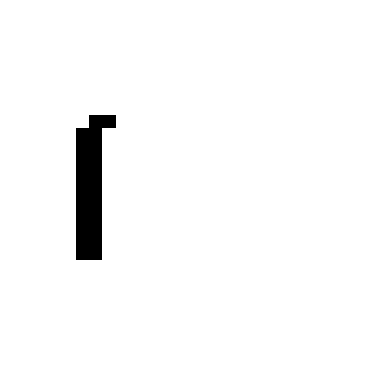

index: 1509
0


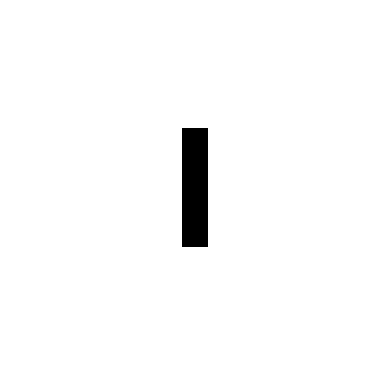

index: 7263
6


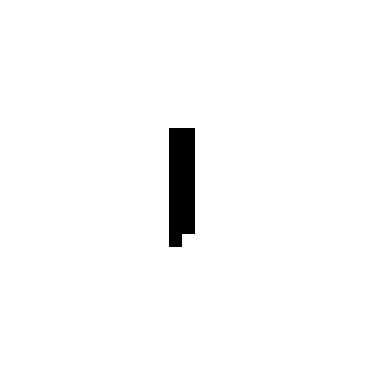

index: 8662
5


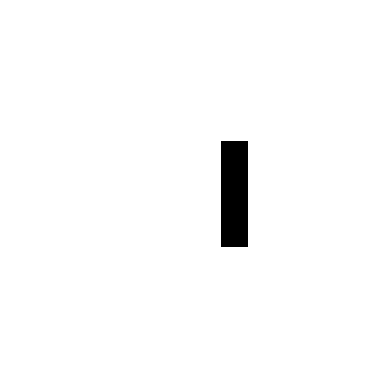

index: 13095
7


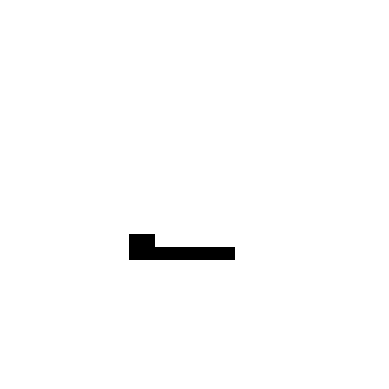

index: 14573
6


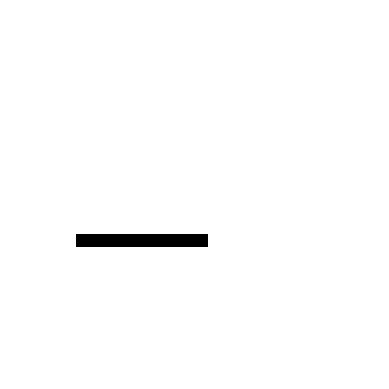

index: 14736
6


In [15]:
for i in list_ours.astype("int64"):
    plot_digit(curr_data_num_trVal["img"][i])
    plt.show()
    print(f"index: {i}")
    print(curr_data_num_trVal["label"][i])

so some are mislabeled(1 -> something else), and one has no img, and some are symbol '-'

In [16]:
num_trVal_img_fixed = curr_data_num_trVal["img"].copy()
num_trVal_label_fixed = curr_data_num_trVal["label"].copy()

In [17]:
print(
num_trVal_label_fixed.shape,
num_trVal_img_fixed.shape
)

(14775,) (14775, 28, 28)


In [18]:
# 1. fix label
# 1509,7263,8662,13095 to '1'

for i in [1509, 7263, 8662, 13095]:
    num_trVal_label_fixed[i] = '1'

In [19]:
print(
num_trVal_label_fixed.shape,
num_trVal_img_fixed.shape
)

(14775,) (14775, 28, 28)


In [20]:
# 2. delete label and img
# 1448, 14573, 14736

num_trVal_label_fixed = np.delete(num_trVal_label_fixed, (1448, 14573, 14736))
num_trVal_img_fixed = np.delete(num_trVal_img_fixed, (1448, 14573, 14736),axis=0)

In [21]:
print(
num_trVal_label_fixed.shape,
num_trVal_img_fixed.shape
)

(14772,) (14772, 28, 28)


so far we relabeled by comparing the labels, but we also have **predict_proba**
we can assume if an img has a low **predict_proba**(even the prediction is correct), we may assume something is wrong about that img

In [22]:
nn_clf_ours.fit(preprocessing(num_trVal_img_fixed), num_trVal_label_fixed)

rebase ongoing
done!
border deletion ongoing
done!
thickening ongoing
done!


Pipeline(steps=[('robustscaler', RobustScaler()),
                ('mlpclassifier',
                 MLPClassifier(max_iter=300, random_state=42, solver='lbfgs'))])

In [23]:
size = np.shape(num_trVal_img_fixed)[0]

list_ours = []
list_ours_score = []

for i in range(size):
    curr = np.reshape(num_trVal_img_fixed[i].copy(), (1, -1))
    label = num_trVal_label_fixed[i]

    prediction = int (nn_clf_ours.predict(curr))
    score_ours = nn_clf_ours.predict_proba(curr)[0,prediction]
    threshold = 0.985

    if score_ours <= threshold:
        list_ours = np.append(list_ours, i)
        list_ours_score = np.append(list_ours_score, score_ours)


In [24]:
len(list_ours)

40

In [25]:
# for i in list_ours.astype("int64"):
#     plot_digit(num_trVal_img_fixed[i])
#     plt.show()
#     print(f"index: {i}")
#     print(num_trVal_label_fixed[i])

In [26]:
# 1. fix label

# 3313, 4210, 7943, 10668, 12129, 12939, 13341, 13964 to '1'
for i in [3313, 4210, 7943, 10668, 12129, 12939, 13341, 13964]:
    num_trVal_label_fixed[i] = '1'
    
# 4953, 8308, 12748 to '0'
for i in [4953, 8308, 12748]:
    num_trVal_label_fixed[i] = '0'
    
# 6960 to '5'
num_trVal_label_fixed[6960] = '5'

# 11256 to '6'
num_trVal_label_fixed[11256] = '6'

# 5058 to '7'
num_trVal_label_fixed[5058] = '7'

# 11256 to '8'
num_trVal_label_fixed[11256] = '8'

In [27]:
# 2. delete label and img
# 4076, 14302, 14573, 14668, 14676, 14686, 14757

num_trVal_label_fixed = np.delete(num_trVal_label_fixed, (4076, 14302, 14573, 14668, 14676, 14686, 14757))
num_trVal_img_fixed = np.delete(num_trVal_img_fixed, (4076, 14302, 14573, 14668, 14676, 14686, 14757),axis=0)

In [28]:
print(
num_trVal_label_fixed.shape,
num_trVal_img_fixed.shape
)

(14765,) (14765, 28, 28)


let's do this to all of our data

## digit test

In [29]:
num_test_img_fixed = curr_data_num_test["img"].copy()
num_test_label_fixed = curr_data_num_test["label"].copy()

In [30]:
X_test_ours, y_test_ours =  preprocessing(curr_data_num_test["img"].copy()), curr_data_num_test["label"].copy()

nn_clf_ours.fit(preprocessing(num_trVal_img_fixed), num_trVal_label_fixed)

rebase ongoing
done!
border deletion ongoing
done!
thickening ongoing
done!
rebase ongoing
done!
border deletion ongoing
done!
thickening ongoing
done!


Pipeline(steps=[('robustscaler', RobustScaler()),
                ('mlpclassifier',
                 MLPClassifier(max_iter=300, random_state=42, solver='lbfgs'))])

In [31]:
# using label mismatch

size = np.shape(X_test_ours)[0]

list_ours = []

for i in range(size):
    curr = np.reshape(X_test_ours[i].copy(), (1,-1))
    label = curr_data_num_test["label"][i]

    predict_ours = nn_clf_ours.predict(curr)

    if predict_ours != label:
        list_ours = np.append(list_ours, i)
    

In [32]:
len(list_ours)

498

too many, lets use the predict_proba

In [33]:
# for i in range(30):
#     plot_digit(num_test_img_fixed[i])
#     plt.show()
#     print(num_test_label_fixed[i])

In [34]:
# using predict_proba

size = np.shape(X_test_ours)[0]

list_ours = []

for i in range(size):
    curr = np.reshape(X_test_ours[i].copy(), (1, -1))
    label = num_test_label_fixed[i]

    prediction = int (nn_clf_ours.predict(curr))
    score_ours = nn_clf_ours.predict_proba(curr)[0,prediction]
    threshold = 0.75

    if score_ours <= threshold:
        list_ours = np.append(list_ours, i)
        
    

In [35]:
len(list_ours)

87

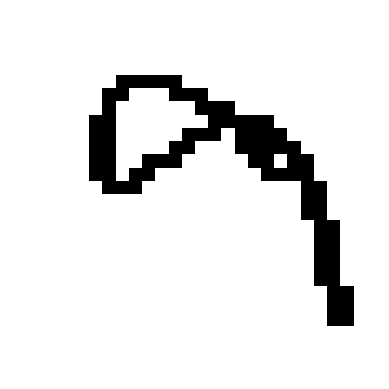

index: 5
9


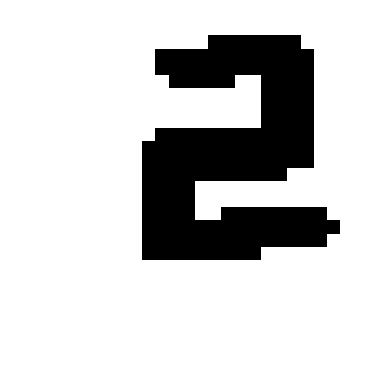

index: 99
2


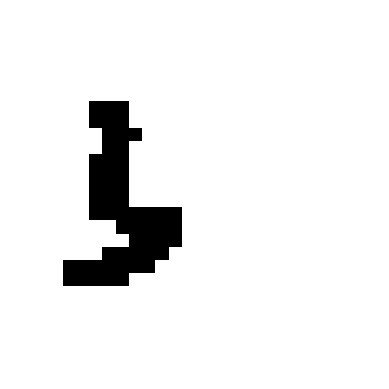

index: 167
3


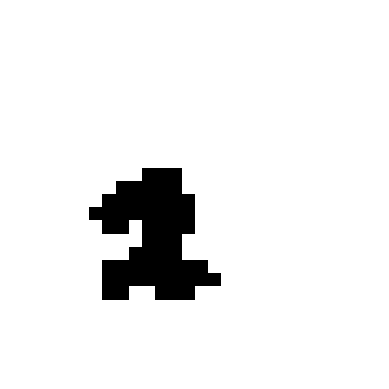

index: 174
2


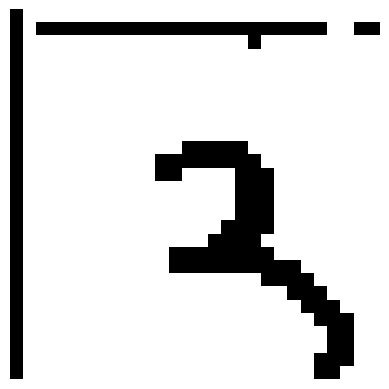

index: 200
3


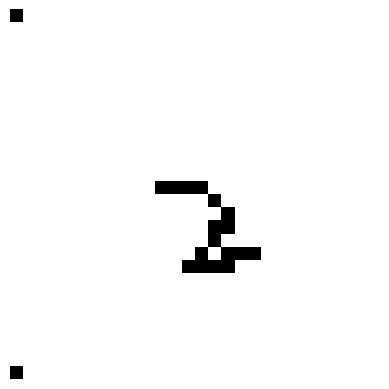

index: 203
2


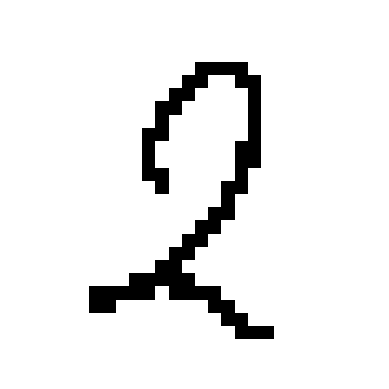

index: 293
2


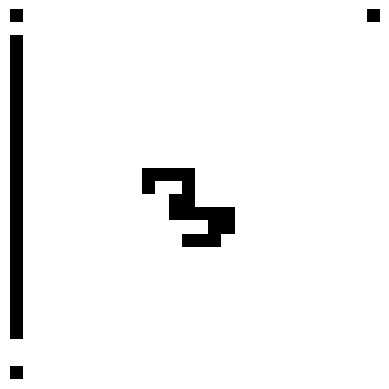

index: 296
3


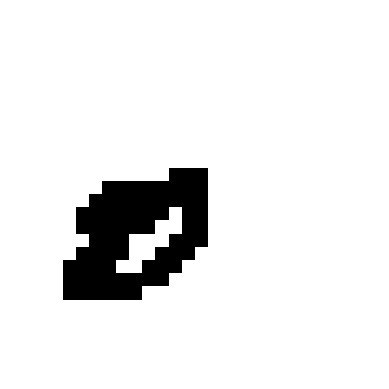

index: 303
0


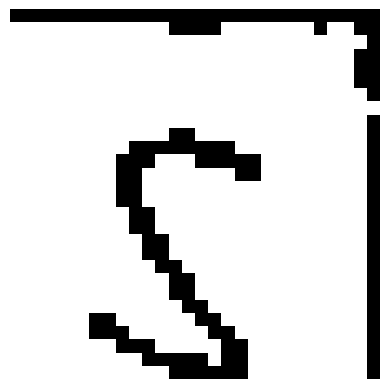

index: 344
5


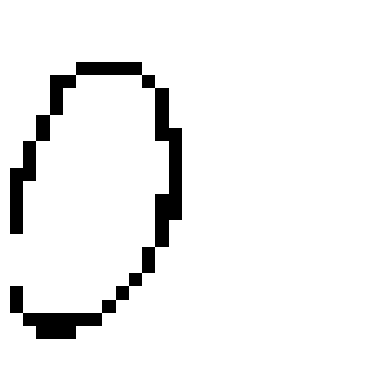

index: 391
0


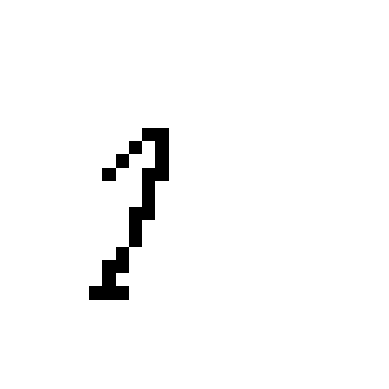

index: 439
1


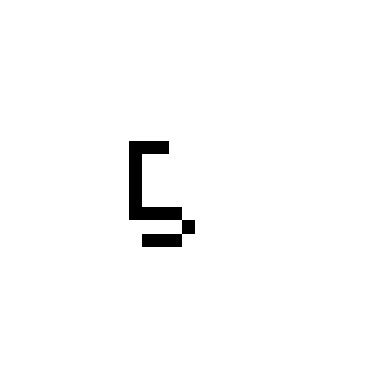

index: 444
5


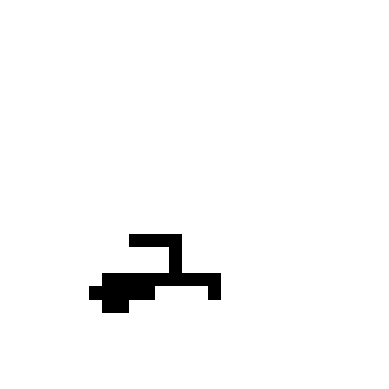

index: 454
2


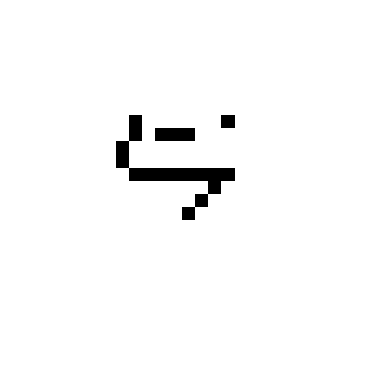

index: 457
5


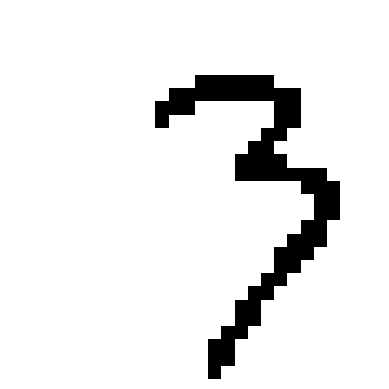

index: 466
3


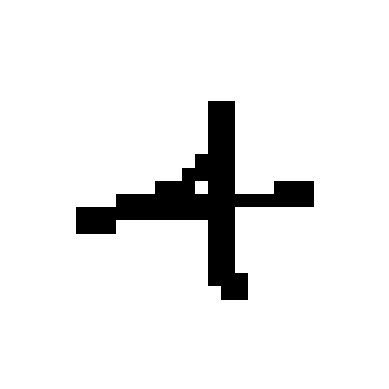

index: 494
4


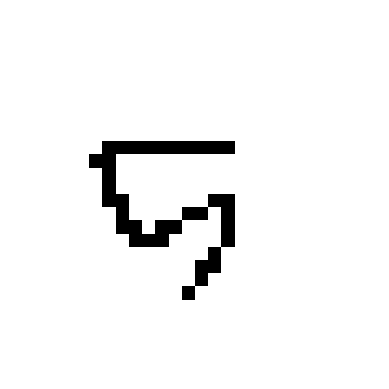

index: 509
5


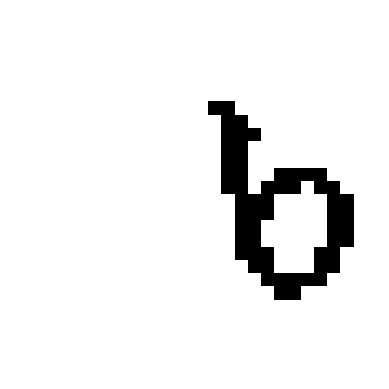

index: 510
6


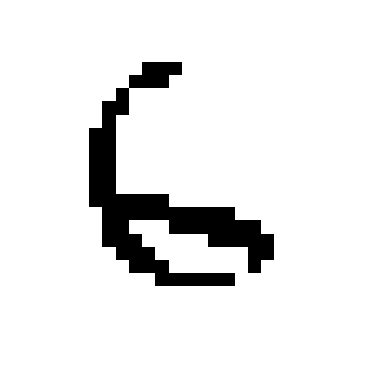

index: 516
3


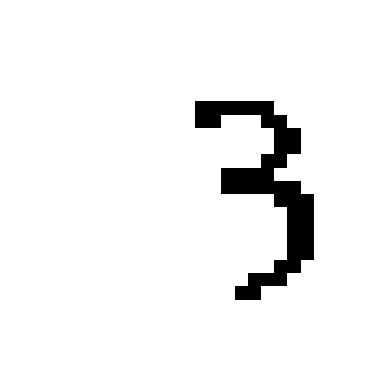

index: 569
3


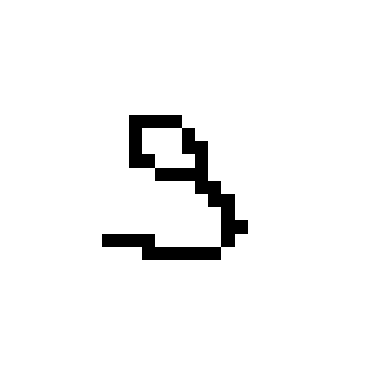

index: 635
3


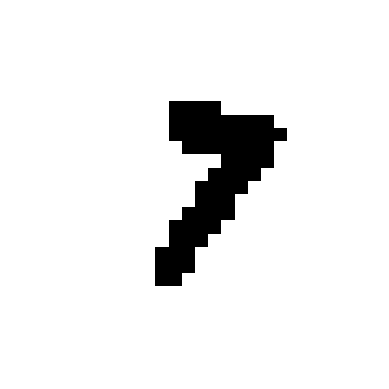

index: 646
7


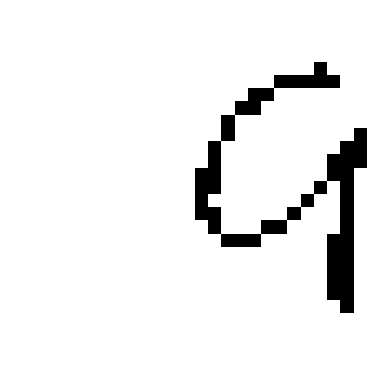

index: 648
9


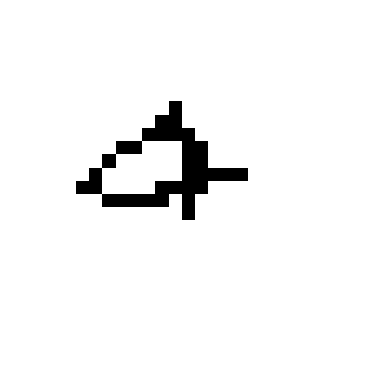

index: 703
4


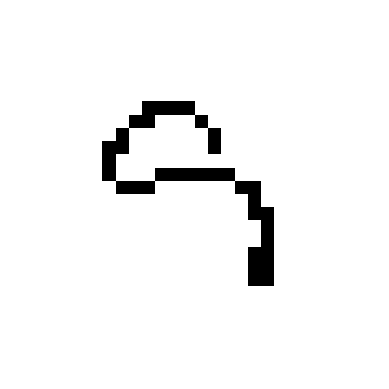

index: 708
9


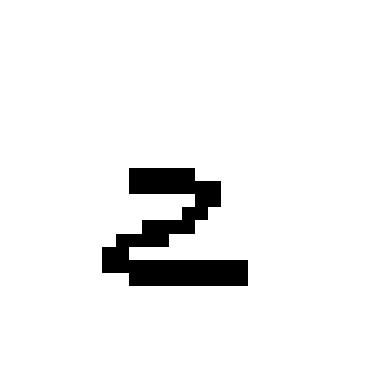

index: 712
2


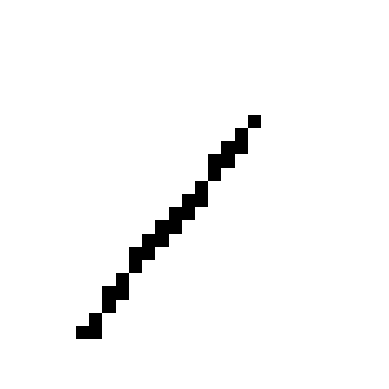

index: 725
1


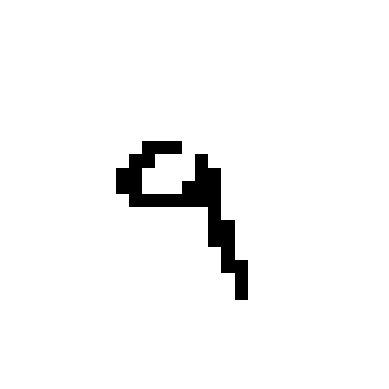

index: 767
8


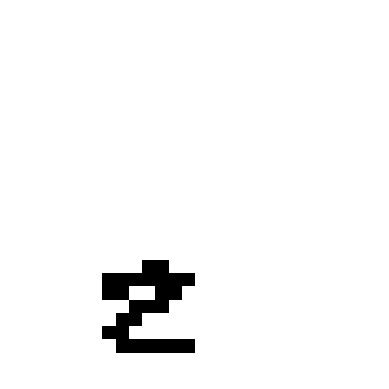

index: 814
2


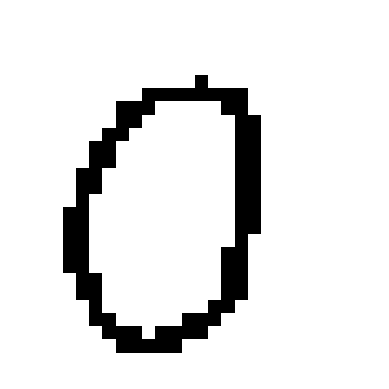

index: 830
0


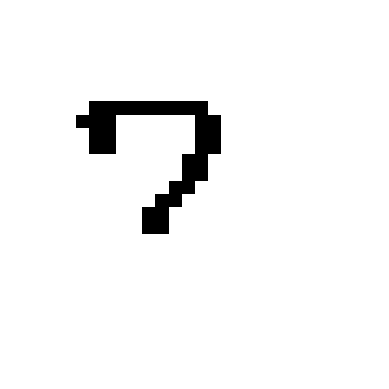

index: 839
7


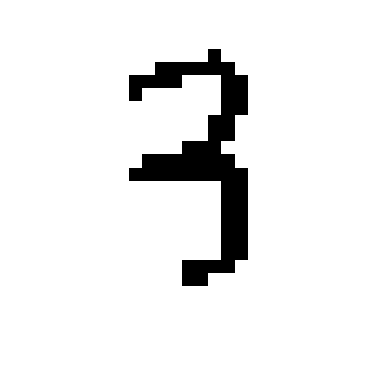

index: 851
2


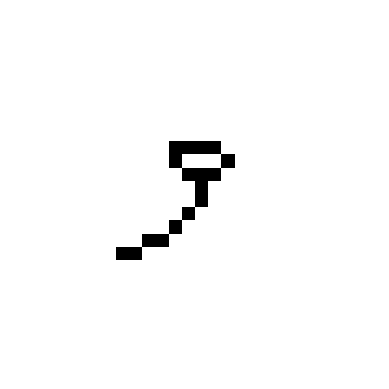

index: 875
9


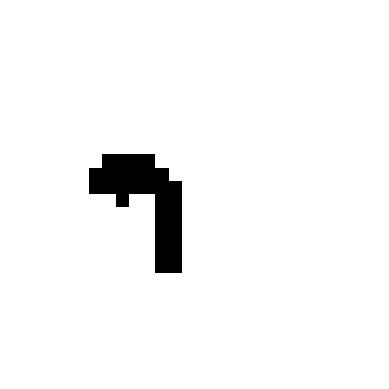

index: 941
9


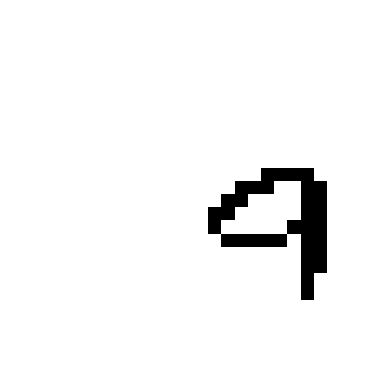

index: 950
9


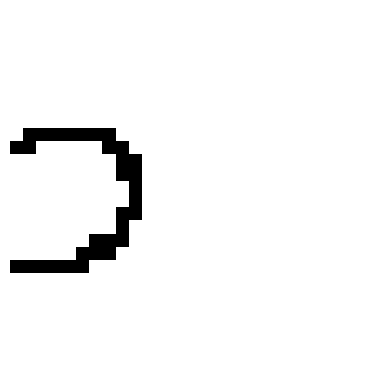

index: 960
0


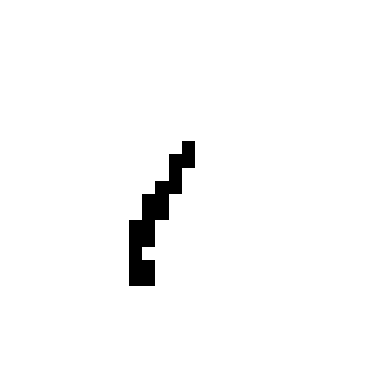

index: 972
1


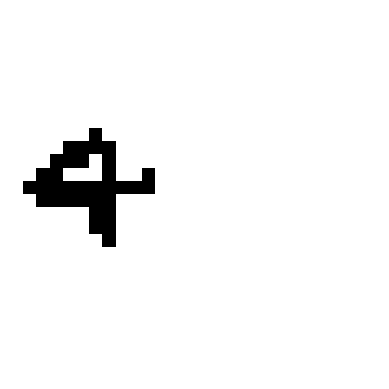

index: 992
0


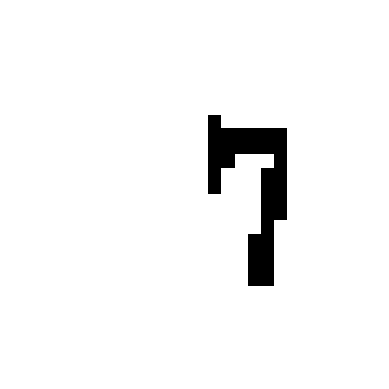

index: 998
6


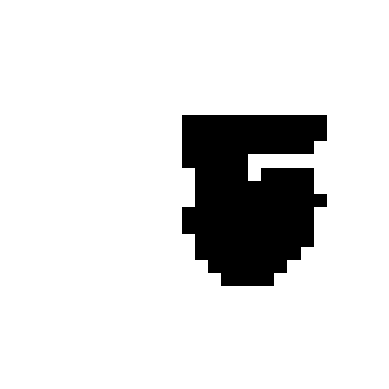

index: 1033
5


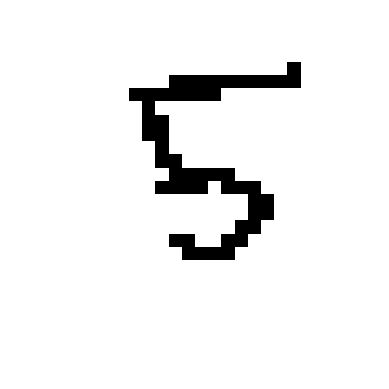

index: 1046
5


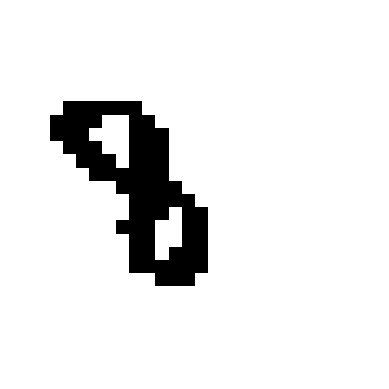

index: 1051
3


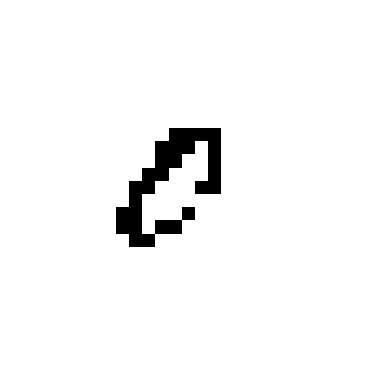

index: 1062
0


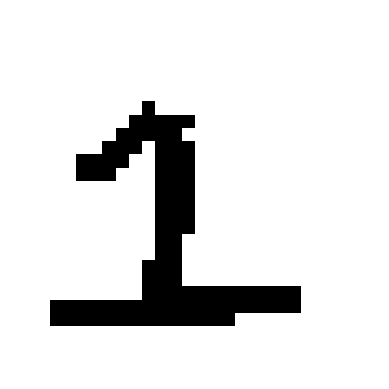

index: 1081
1


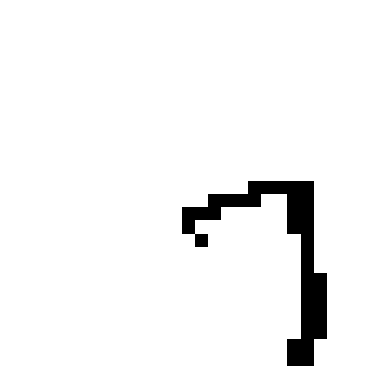

index: 1098
7


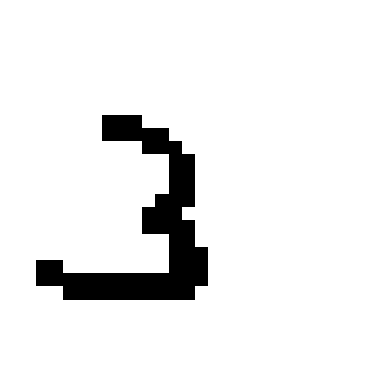

index: 1108
3


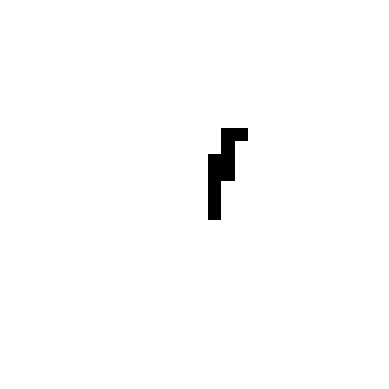

index: 1150
1


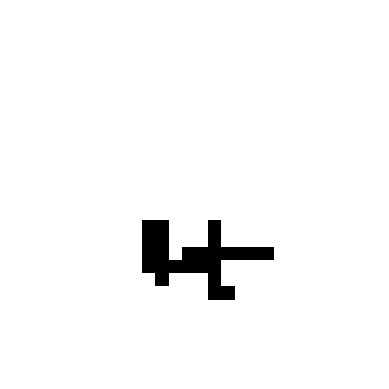

index: 1178
4


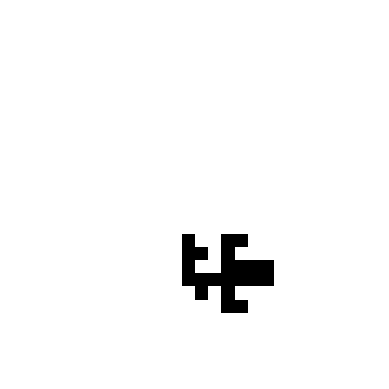

index: 1179
4


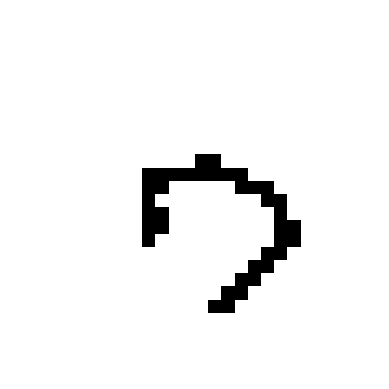

index: 1184
7


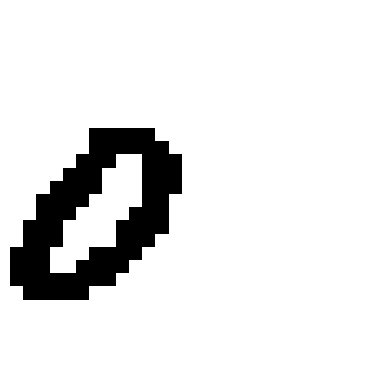

index: 1201
0


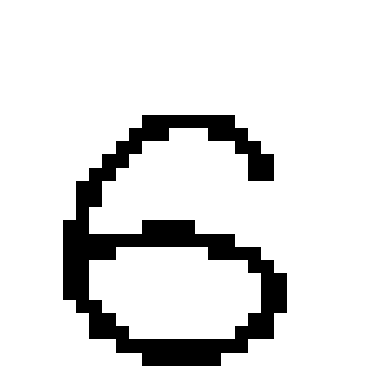

index: 1204
6


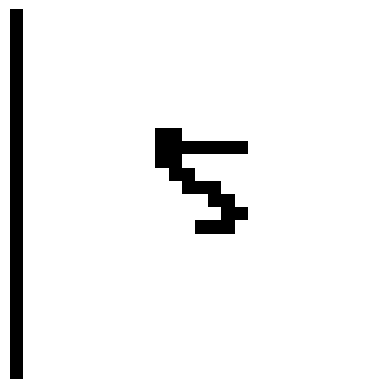

index: 1228
5


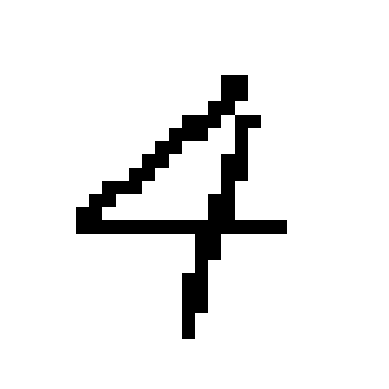

index: 1282
4


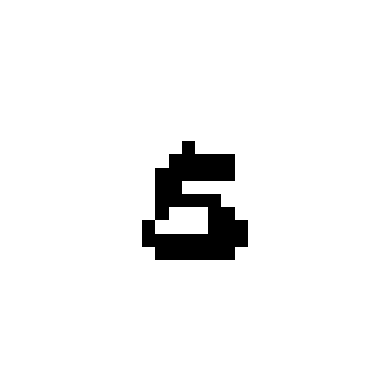

index: 1382
5


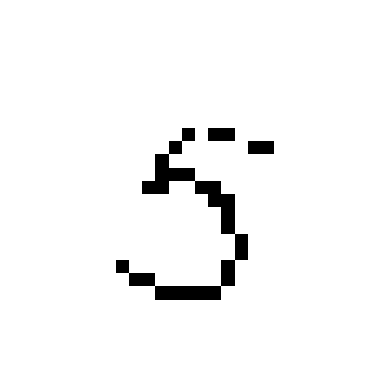

index: 1394
5


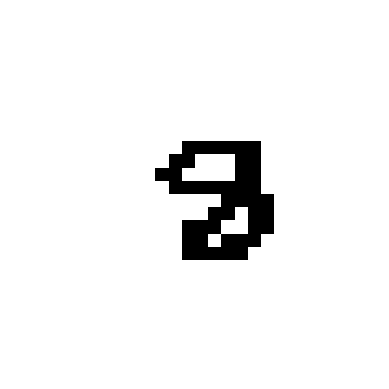

index: 1481
7


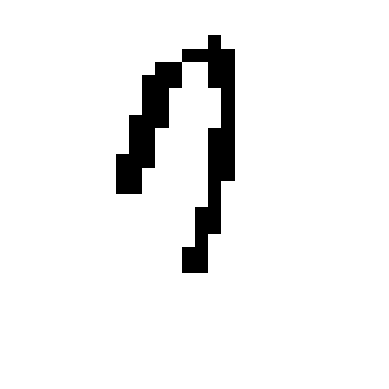

index: 1549
7


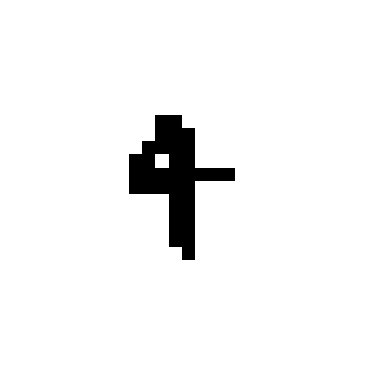

index: 1572
4


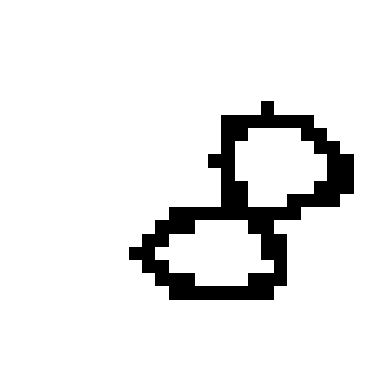

index: 1574
8


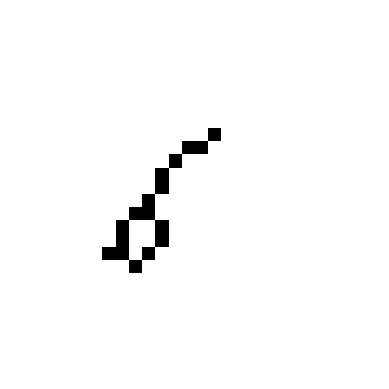

index: 1579
6


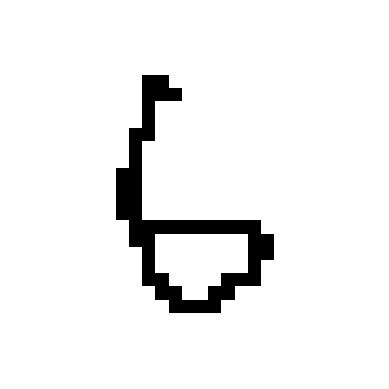

index: 1622
0


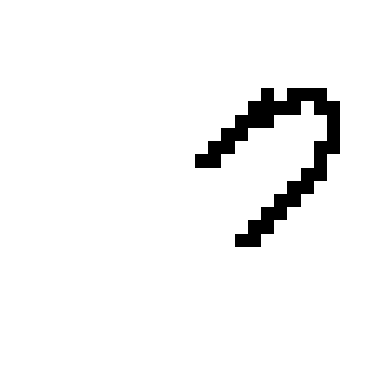

index: 1631
7


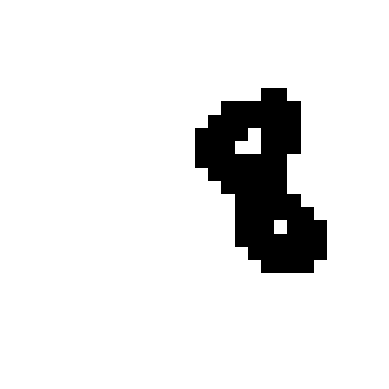

index: 1639
8


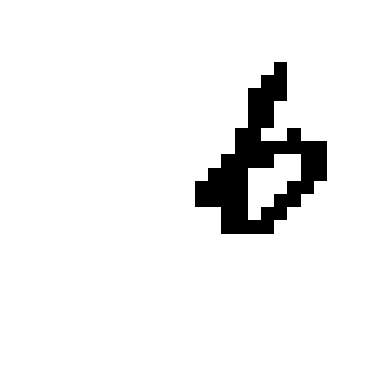

index: 1640
6


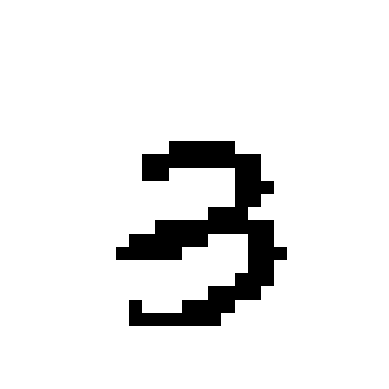

index: 1658
3


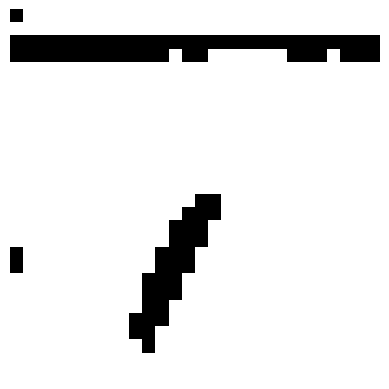

index: 1669
1


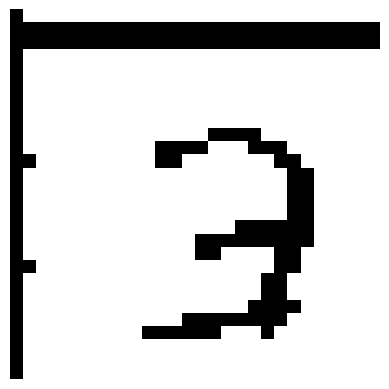

index: 1722
3


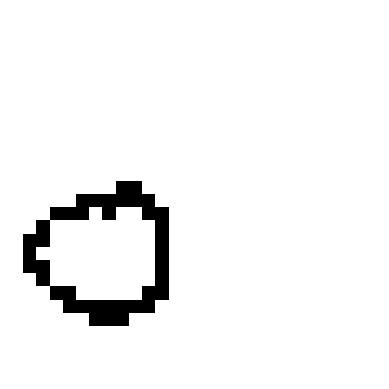

index: 1723
0


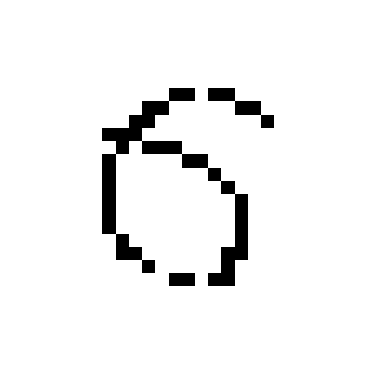

index: 1729
6


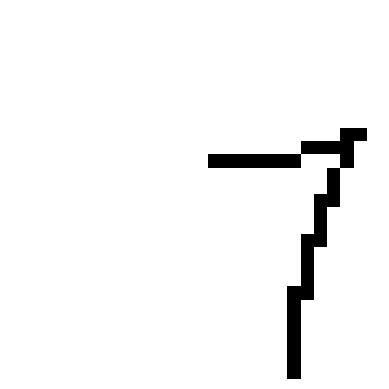

index: 1793
7


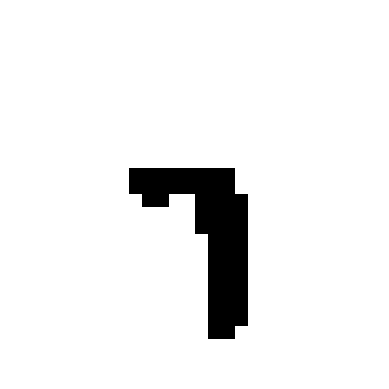

index: 1865
7


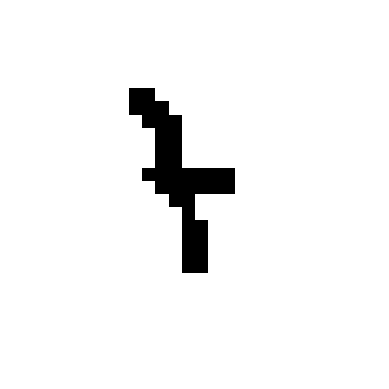

index: 1883
3


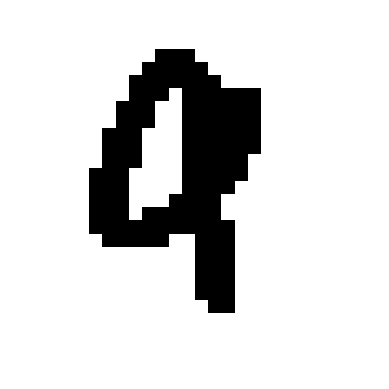

index: 1925
9


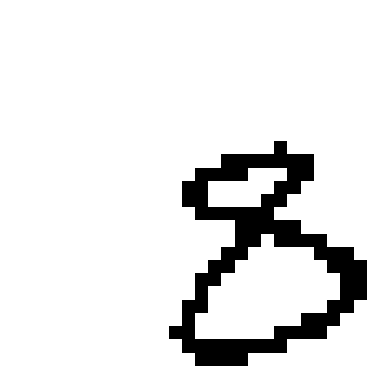

index: 1983
8


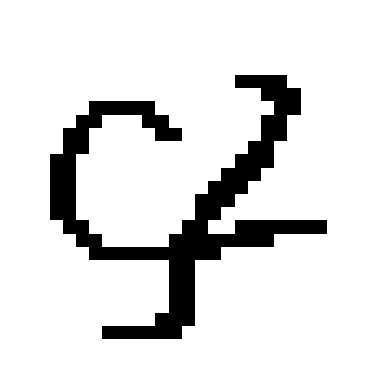

index: 1995
4


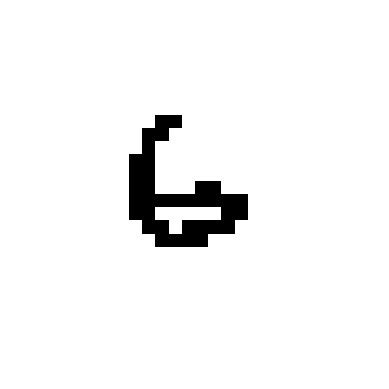

index: 2000
6


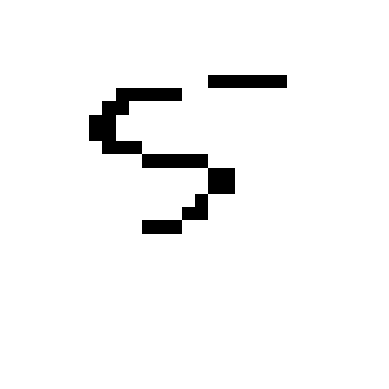

index: 2008
8


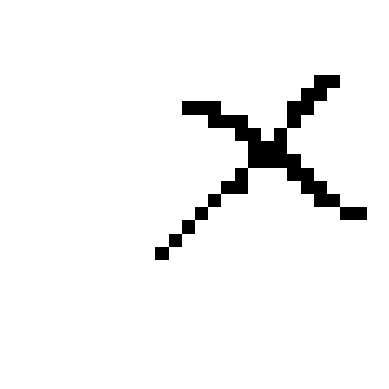

index: 2068
7


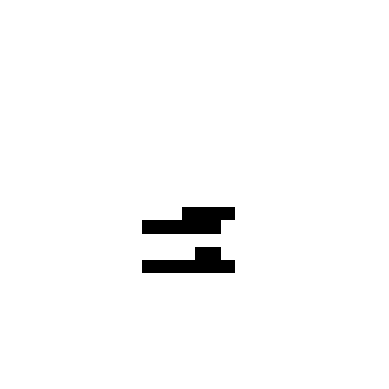

index: 2074
4


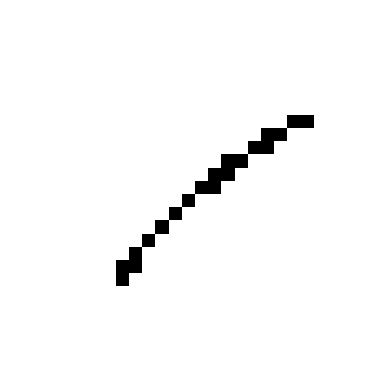

index: 2083
8


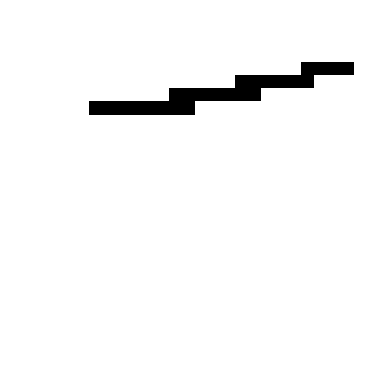

index: 2094
1


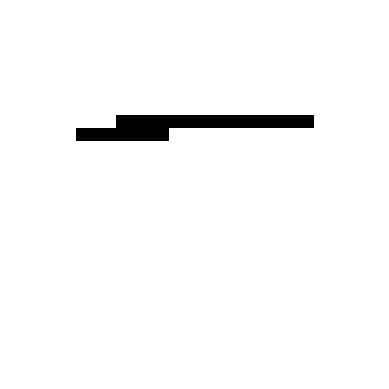

index: 2098
1


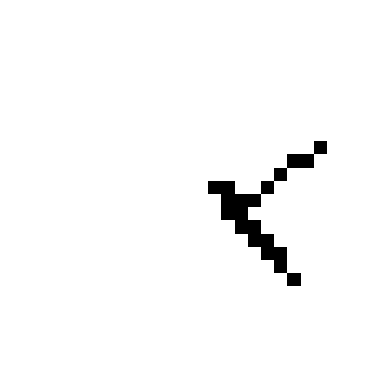

index: 2100
7


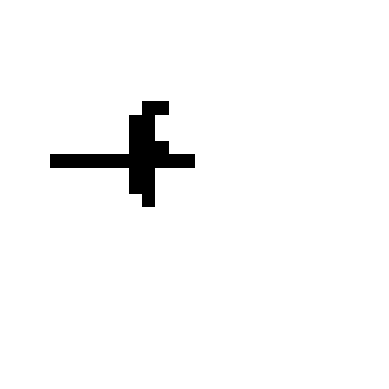

index: 2101
0


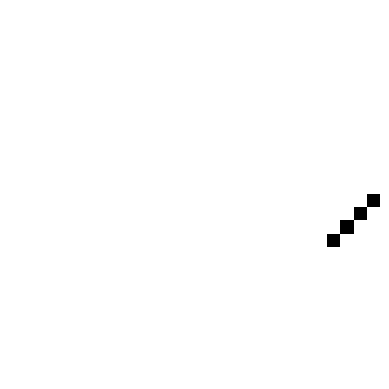

index: 2111
8


In [36]:
for i in list_ours.astype("int64"):
    plot_digit(num_test_img_fixed[i])
    plt.show()
    print(f"index: {i}")
    print(num_test_label_fixed[i])

In [37]:
# 1. fix label

# 851 to '2'
num_test_label_fixed[851] = '2'

# 992 to '4'
num_test_label_fixed[992] = '4'

# 2008 to '5'
num_test_label_fixed[2008] = '5'

# 516, 998, 1622 to '6'
for i in [516,998,1622]:
    num_test_label_fixed[i] = '6'

# 1051, 1481 to '8'
for i in [516,998,1622]:
    num_test_label_fixed[i] = '8'

# 767 to '9'
num_test_label_fixed[767] = '9'

# 2. delete label and img

# 635, 725, 960, 1033, 1883, 2068, 2074, 2083, 2098, 2100, 2101, 2111, 2094

num_test_label_fixed = np.delete(num_test_label_fixed, (635, 725, 960, 1033, 1883, 2068, 2074, 2083, 2098, 2100, 2101, 2111, 2094))
num_test_img_fixed = np.delete(num_test_img_fixed, (635, 725, 960, 1033, 1883, 2068, 2074, 2083, 2098, 2100, 2101, 2111, 2094), axis=0)

In [38]:
print(
num_test_label_fixed.shape,
num_test_img_fixed.shape
)

(2099,) (2099, 28, 28)


## symbolic trVal

In [39]:
sym_trVal_img_fixed = curr_data_sym_trVal["img"].copy()
sym_trVal_label_fixed = curr_data_sym_trVal["label"].copy()

In [40]:
X_train_ours, y_train_ours = preprocessing(sym_trVal_img_fixed), sym_trVal_label_fixed

nn_clf_ours.fit(X_train_ours, y_train_ours)

rebase ongoing
done!
border deletion ongoing
done!
thickening ongoing
done!


Pipeline(steps=[('robustscaler', RobustScaler()),
                ('mlpclassifier',
                 MLPClassifier(max_iter=300, random_state=42, solver='lbfgs'))])

In [41]:
# using label mismatch

size = np.shape(X_train_ours)[0]

list_ours = []

for i in range(size):
    curr = np.reshape(X_train_ours[i].copy(), (1,-1))
    label = sym_trVal_label_fixed[i]

    predict_ours = nn_clf_ours.predict(curr)

    if predict_ours != label:
        list_ours = np.append(list_ours, i)
    

In [42]:
len(list_ours)

54

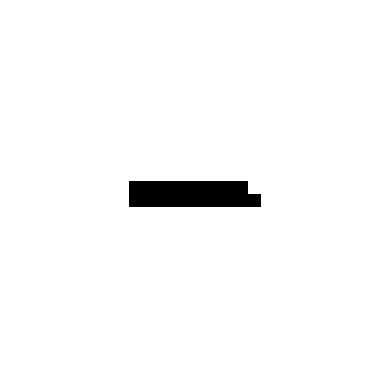

index: 90
+


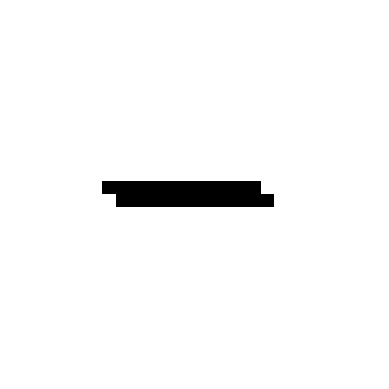

index: 732
-


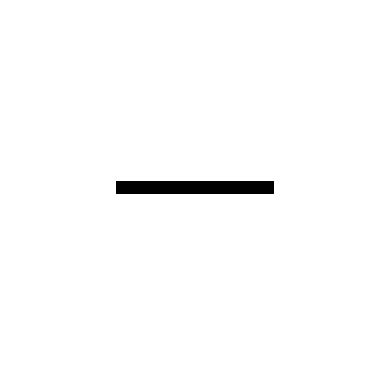

index: 896
=


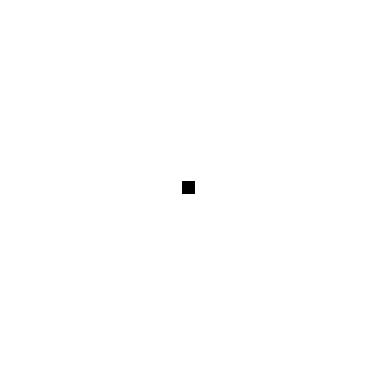

index: 1236
=


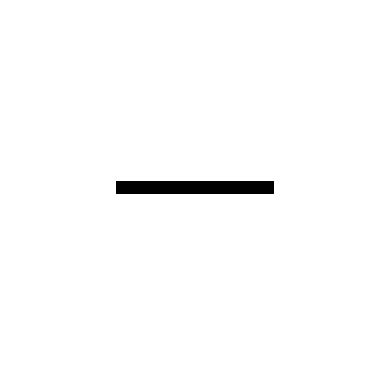

index: 1779
=


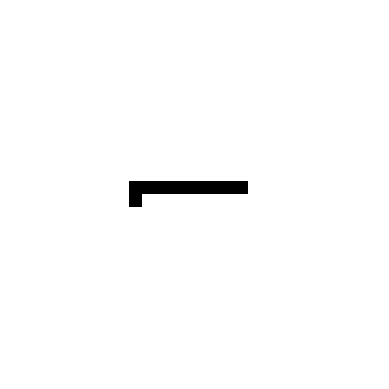

index: 1827
-


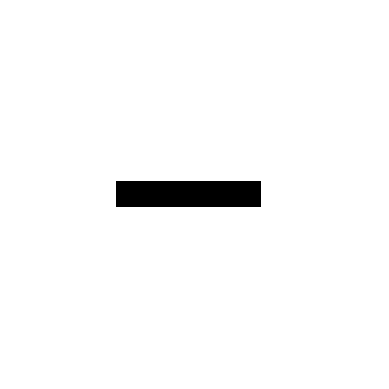

index: 1894
+


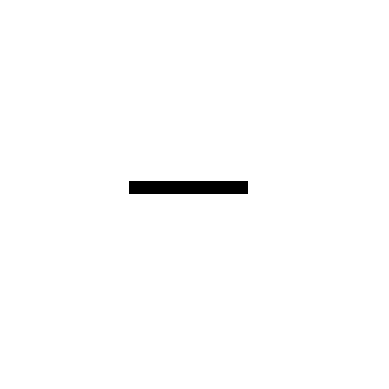

index: 2136
/


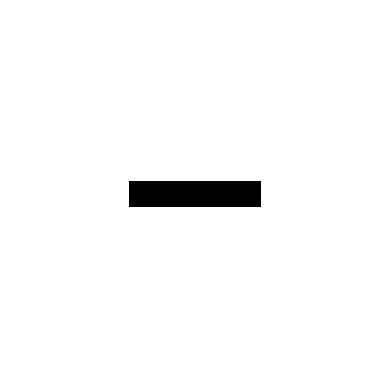

index: 2732
/


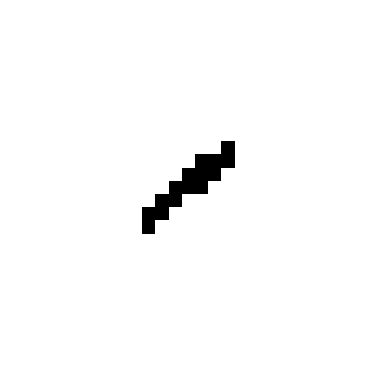

index: 3494
+


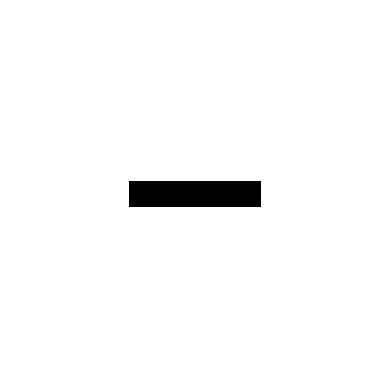

index: 3636
/


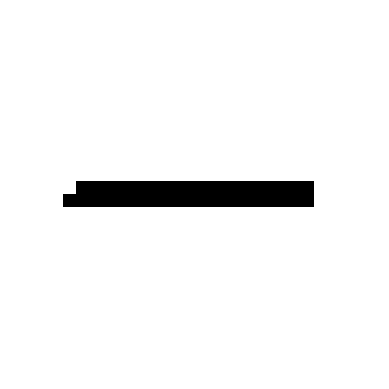

index: 3688
+


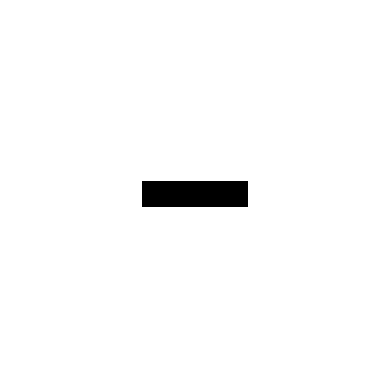

index: 3739
+


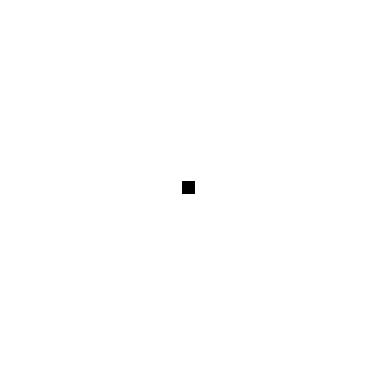

index: 4163
=


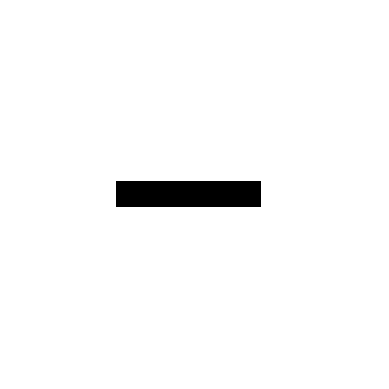

index: 4708
+


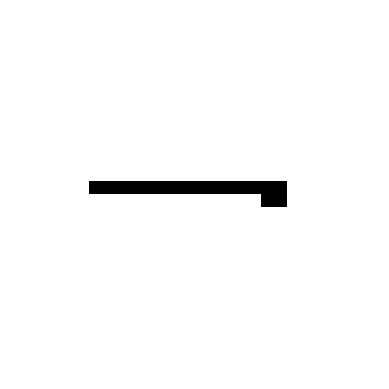

index: 4879
=


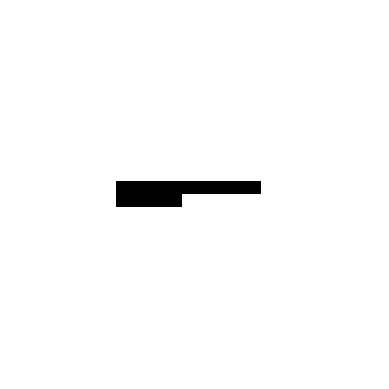

index: 5014
/


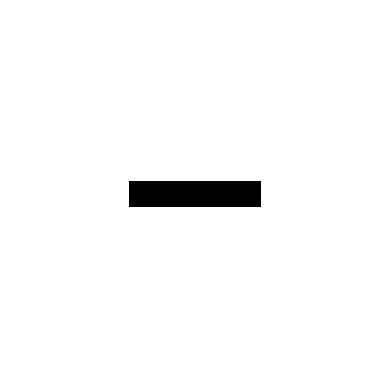

index: 5468
x


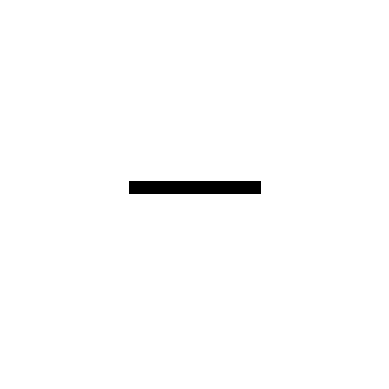

index: 5508
=


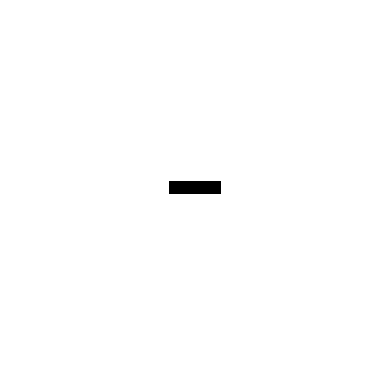

index: 5905
=


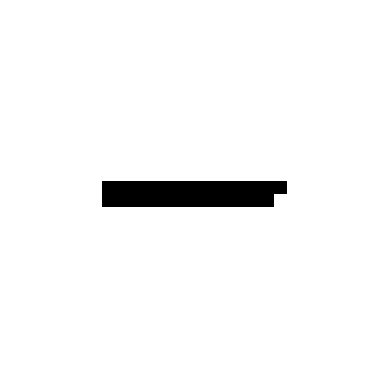

index: 6124
/


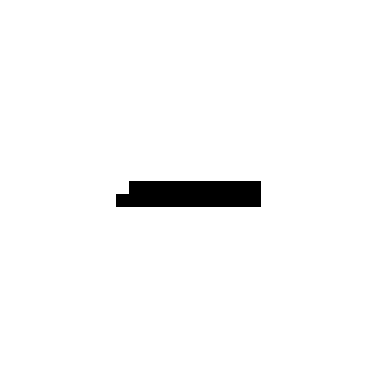

index: 6176
-


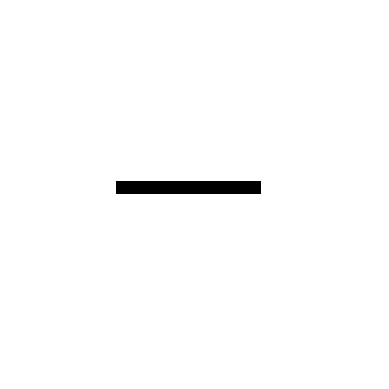

index: 6952
x


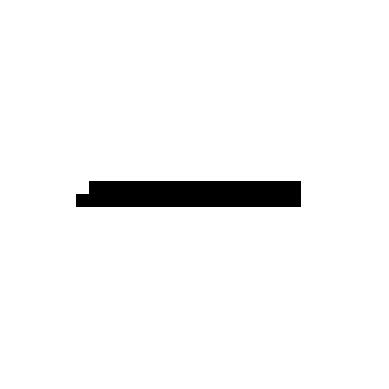

index: 7145
x


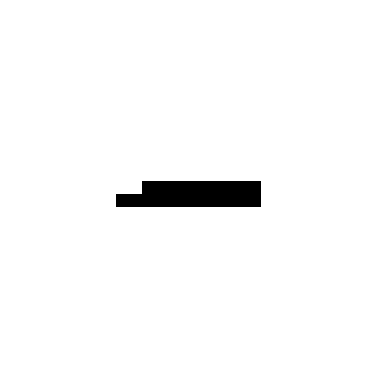

index: 7318
-


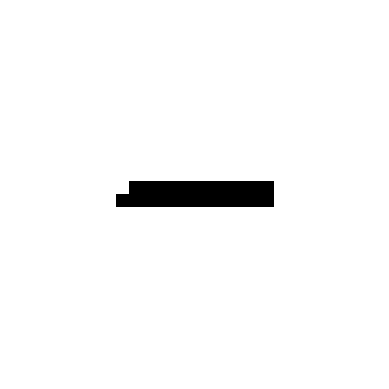

index: 8305
=


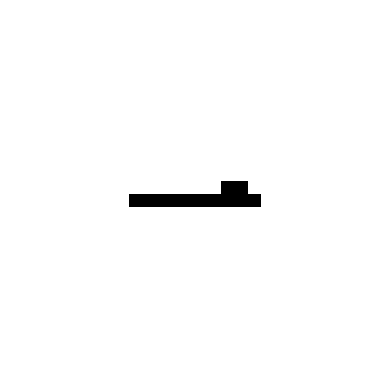

index: 8546
-


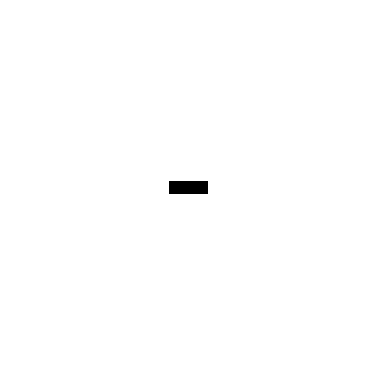

index: 8915
-


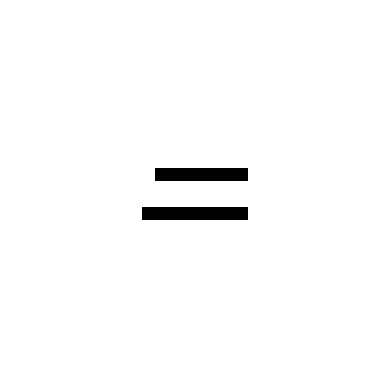

index: 8961
=


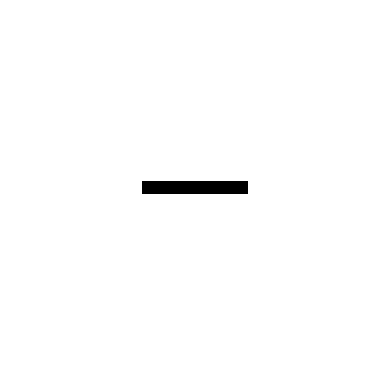

index: 10340
+


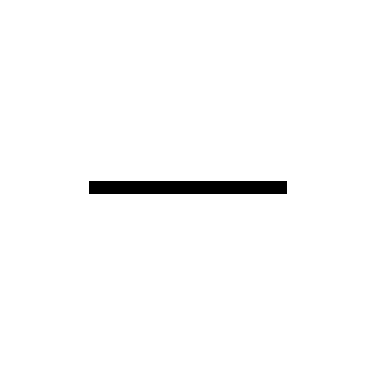

index: 10373
+


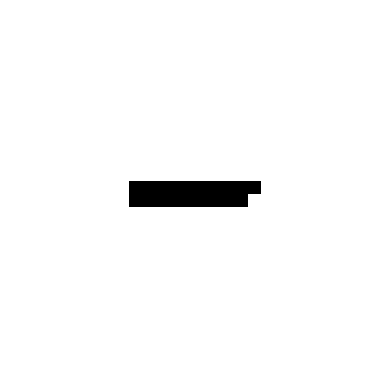

index: 10521
x


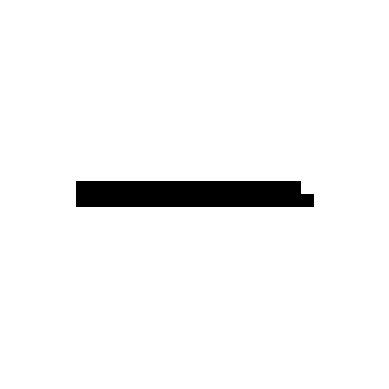

index: 10620
+


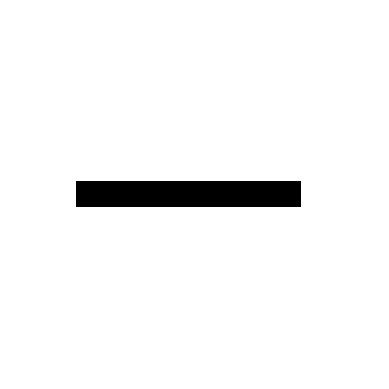

index: 11067
+


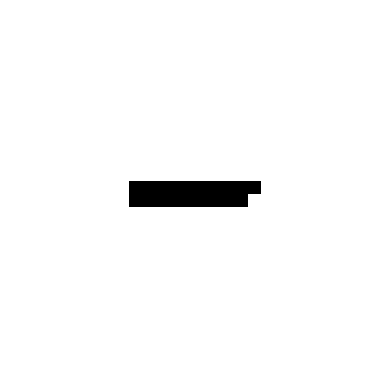

index: 11102
x


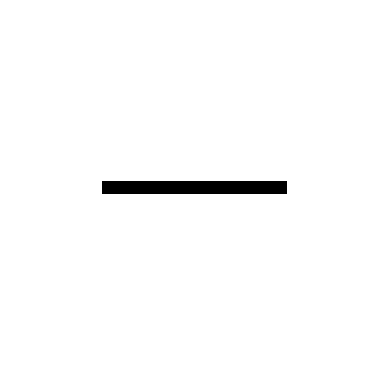

index: 11232
/


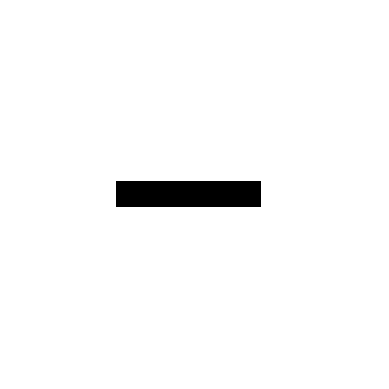

index: 11663
/


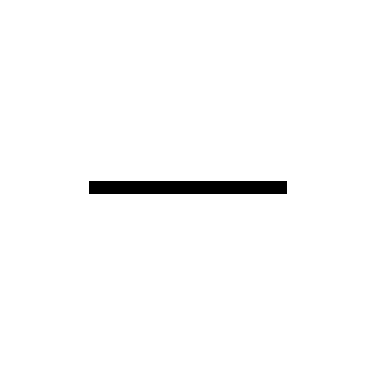

index: 11785
+


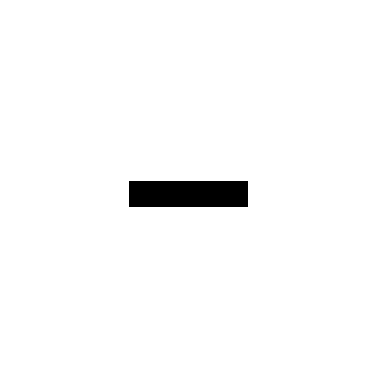

index: 12396
=


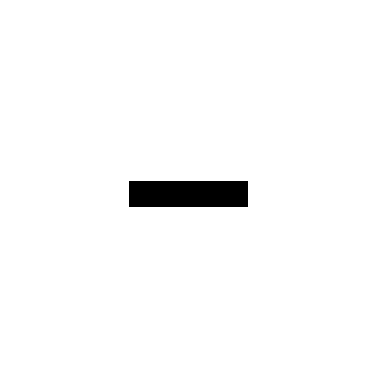

index: 12455
/


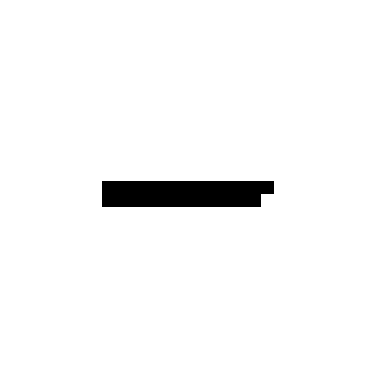

index: 12739
=


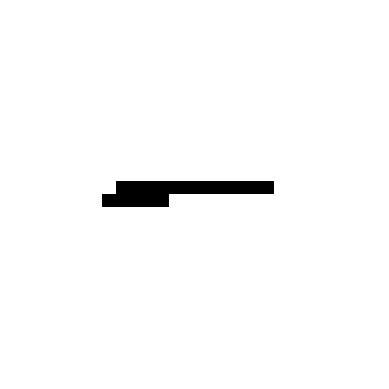

index: 13331
/


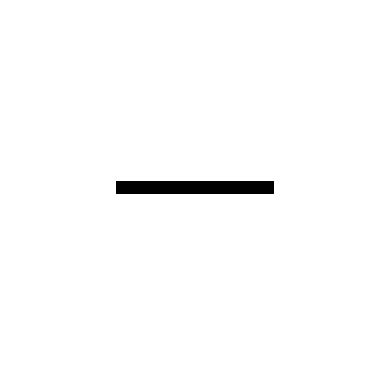

index: 13357
/


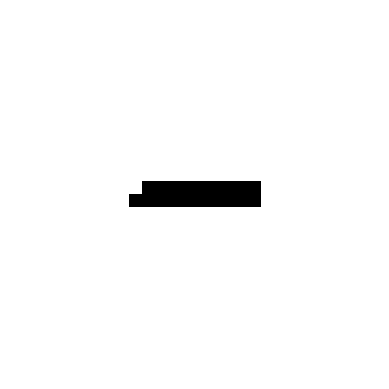

index: 13564
/


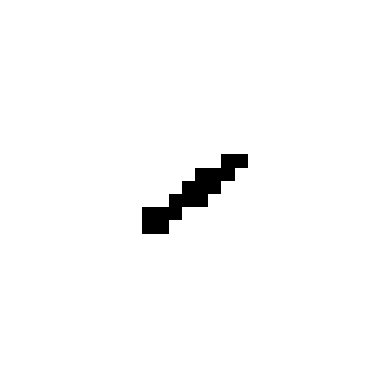

index: 13635
=


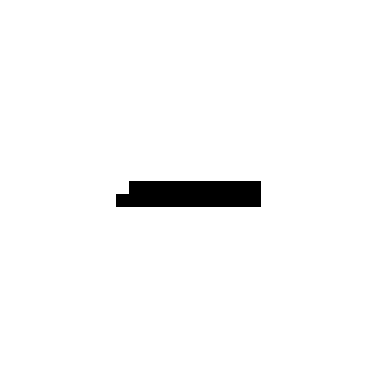

index: 13732
+


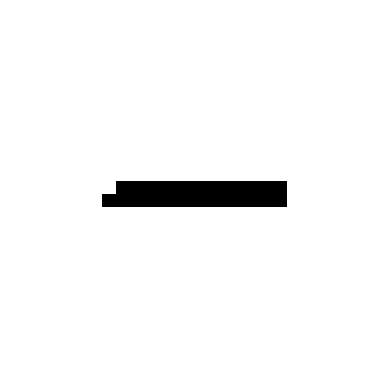

index: 13803
+


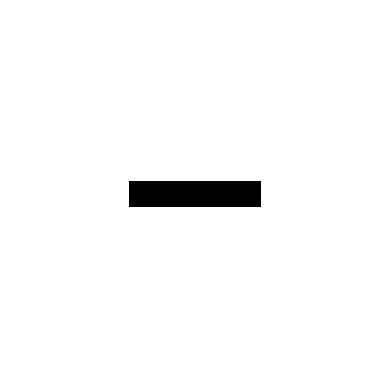

index: 13872
=


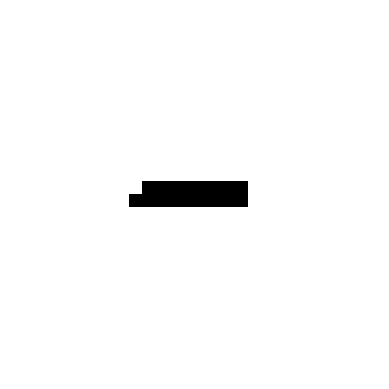

index: 14214
=


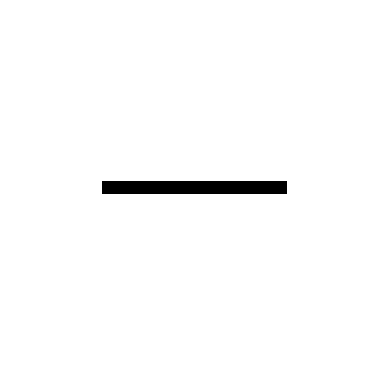

index: 14238
x


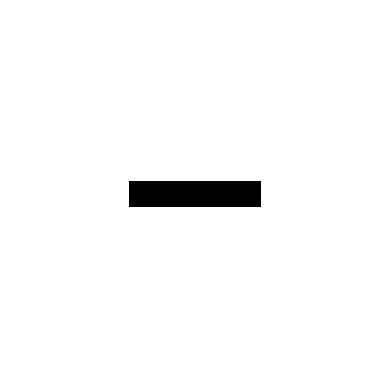

index: 14477
+


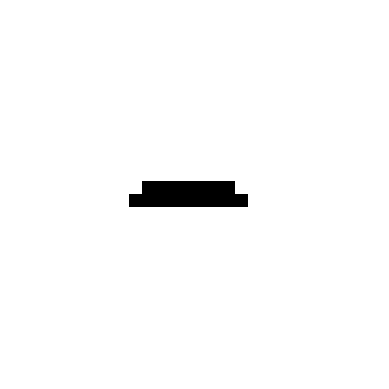

index: 14764
+


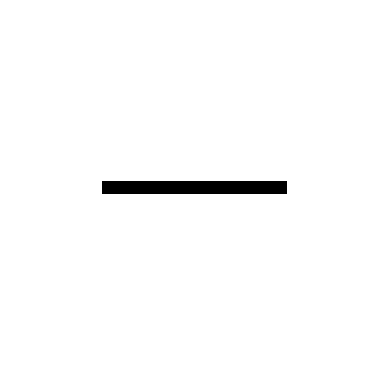

index: 15164
+


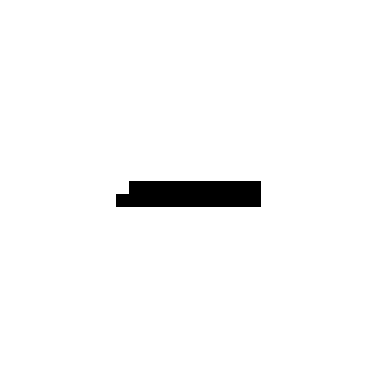

index: 15657
-


In [43]:
for i in list_ours.astype("int64"):
    plot_digit(sym_trVal_img_fixed[i])
    plt.show()
    print(f"index: {i}")
    print(sym_trVal_label_fixed[i])

In [44]:
# 1. fix label

# 896 to '='
sym_trVal_label_fixed[896] = '='

# 13635 to '/'
sym_trVal_label_fixed[13635] = '/'

# 90, 1779, 1894, 2136, 2732, 3494, 3636, 3688, 3739, 4708, 4879, 5014, 5468, 5508, 5905, 6124, 6952, 7145, 8305, 10340, 10373, 10521, 10620, 11067, 11102, 11232, 11668, 11785, 12396, 12455, 12739, 13331, 13357, 13564, 13772, 13803, 13872, 14214, 14238, 14477, 14764, 15164 to '-'

for i in [90, 1779, 1894, 2136, 2732, 3494, 3636, 3688, 3739, 4708, 4879, 5014, 5468, 5508, 5905, 6124, 6952, 7145, 8305, 10340, 10373, 10521, 10620, 11067, 11102, 11232, 11668, 11785, 12396, 12455, 12739, 13331, 13357, 13564, 13772, 13803, 13872, 14214, 14238, 14477, 14764, 15164]:
    sym_trVal_label_fixed[i] = '-'

# 1236, 4163 to 'x'
for i in [516,998,1622]:
    sym_trVal_label_fixed[i] = 'x'

# 2. delete label and img

# 1236, 4163

sym_trVal_label_fixed = np.delete(sym_trVal_label_fixed, (1236, 4163))
sym_trVal_img_fixed = np.delete(sym_trVal_img_fixed, (1236, 4163), axis=0)

In [52]:
print(
    sym_trVal_label_fixed.shape,
    sym_trVal_img_fixed.shape
)

(15671,) (15671, 28, 28)


## symbolic test

In [45]:
sym_test_img_fixed = curr_data_sym_test["img"].copy()
sym_test_label_fixed = curr_data_sym_test["label"].copy()

In [46]:
X_test_ours, y_test_ours = preprocessing(sym_test_img_fixed), sym_test_label_fixed

rebase ongoing
done!
border deletion ongoing
done!
thickening ongoing
done!


In [47]:
# using label mismatch

size = np.shape(X_test_ours)[0]

list_ours = []

for i in range(size):
    curr = np.reshape(X_test_ours[i].copy(), (1,-1))
    label = sym_test_label_fixed[i]

    predict_ours = nn_clf_ours.predict(curr)

    if predict_ours != label:
        list_ours = np.append(list_ours, i)
    

In [48]:
len(list_ours)

145

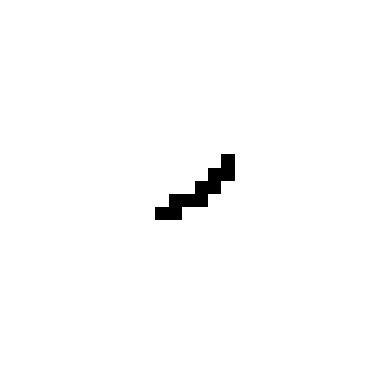

index: 6
/


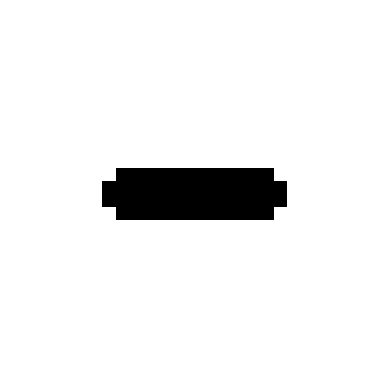

index: 11
-


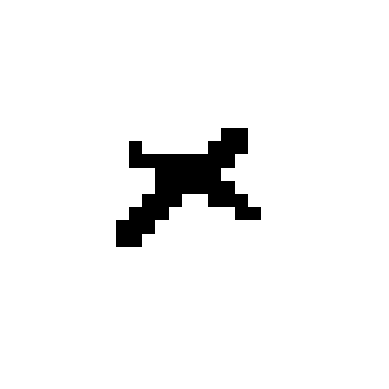

index: 17
+


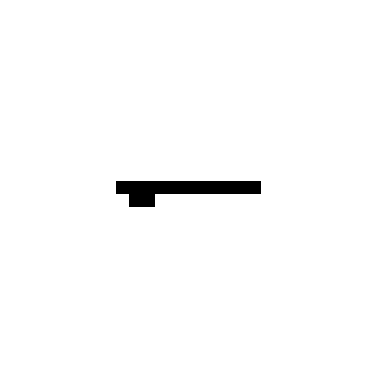

index: 24
-


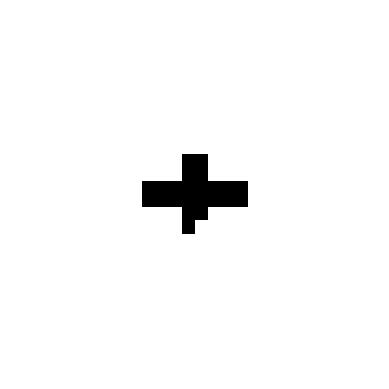

index: 37
/


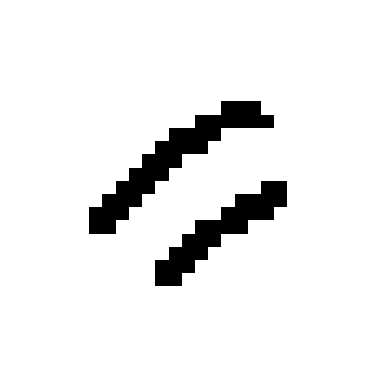

index: 61
=


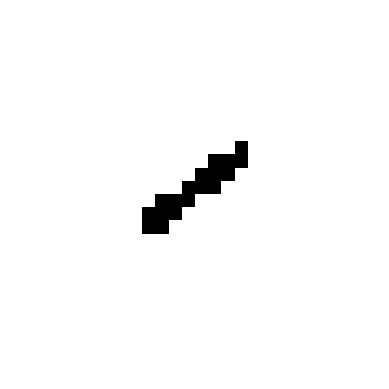

index: 78
/


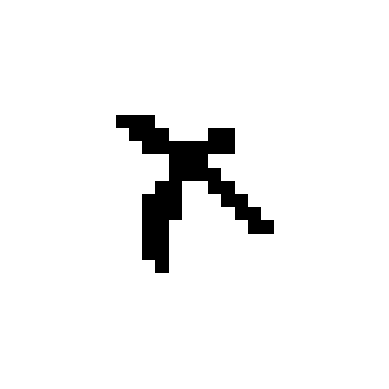

index: 82
x


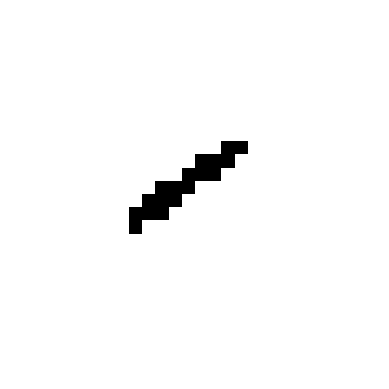

index: 90
-


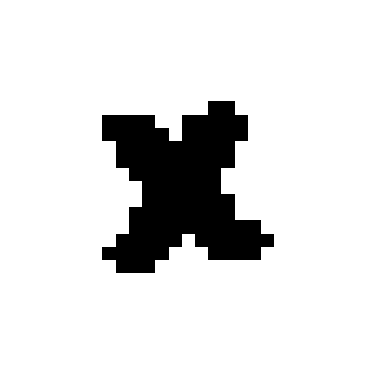

index: 156
x


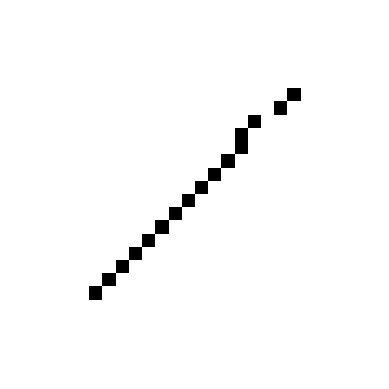

index: 164
+


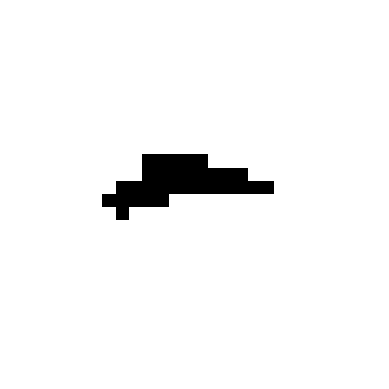

index: 173
=


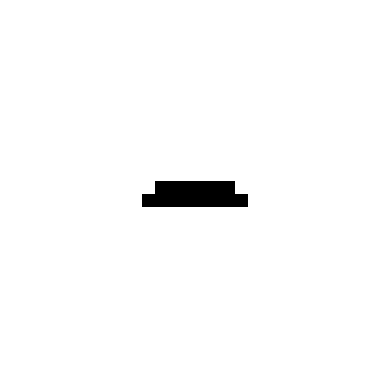

index: 183
+


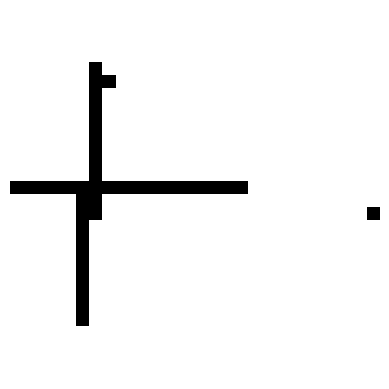

index: 208
+


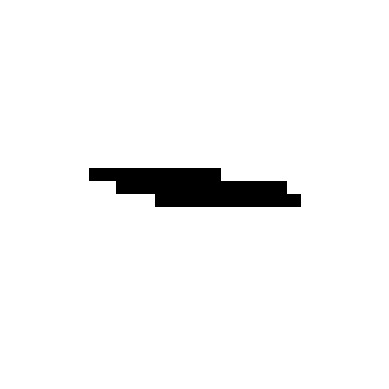

index: 225
-


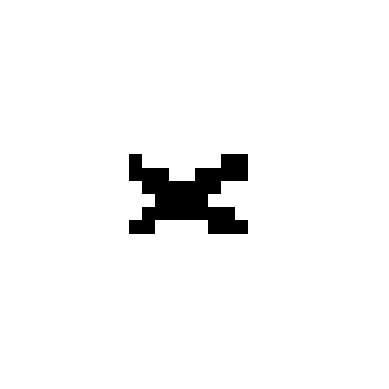

index: 246
-


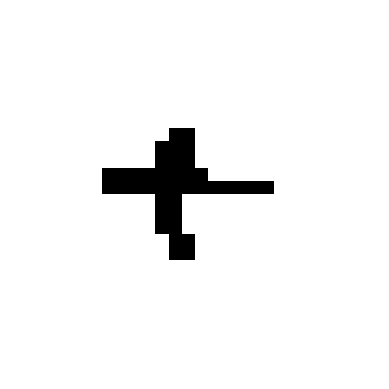

index: 273
-


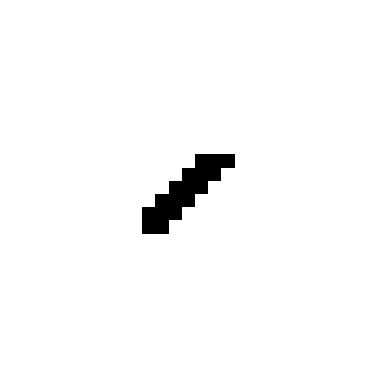

index: 282
/


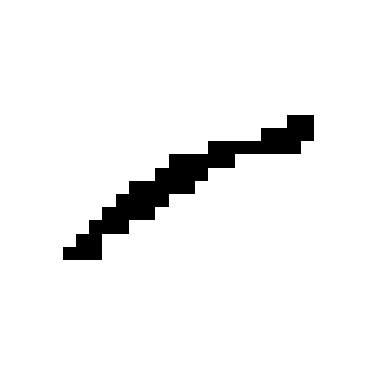

index: 291
x


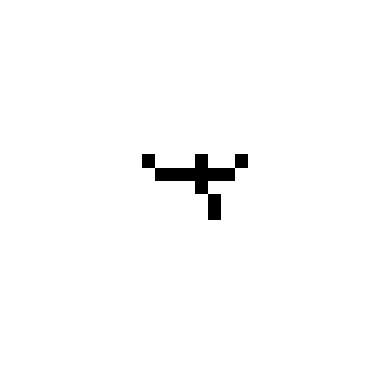

index: 292
+


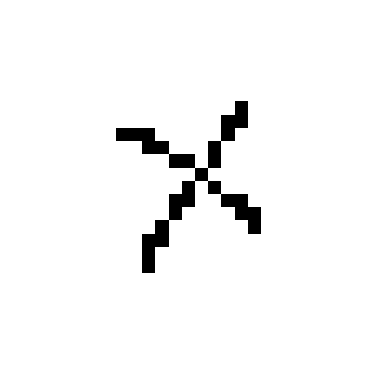

index: 309
x


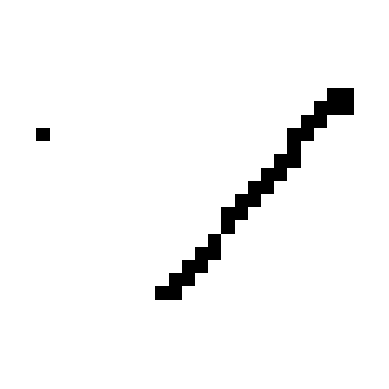

index: 337
/


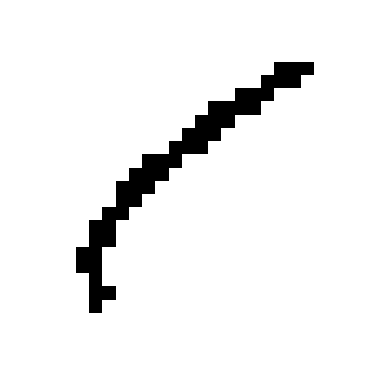

index: 344
/


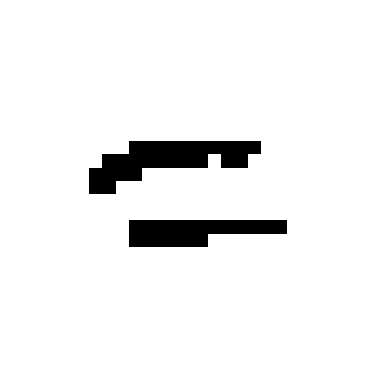

index: 356
/


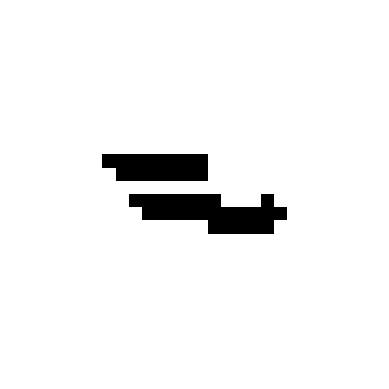

index: 366
/


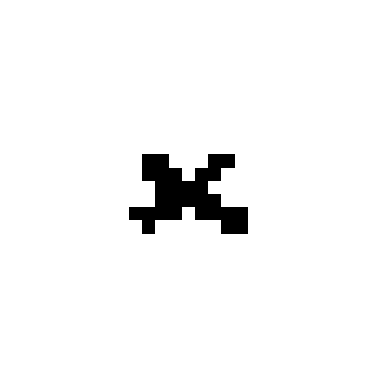

index: 396
=


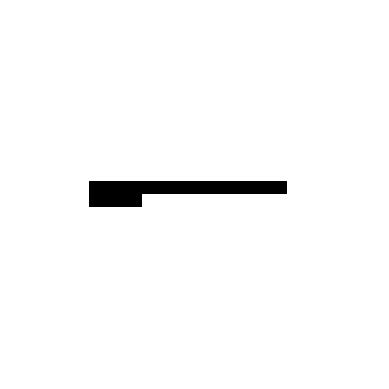

index: 402
=


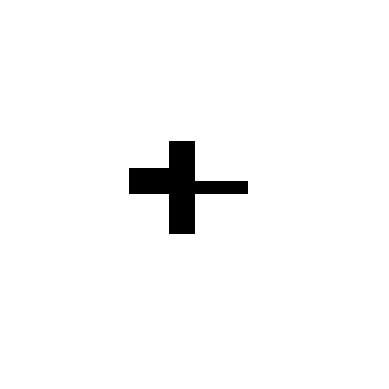

index: 425
+


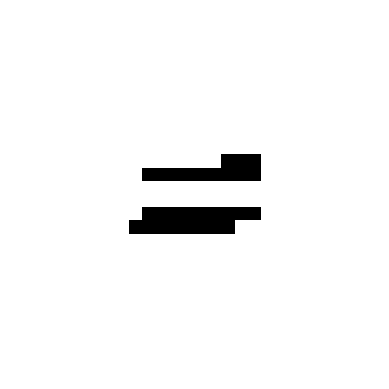

index: 431
=


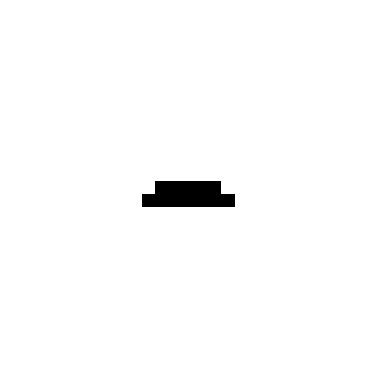

index: 448
+


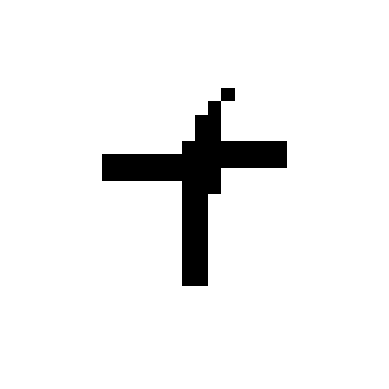

index: 451
-


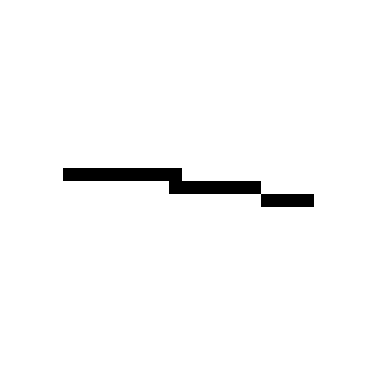

index: 456
-


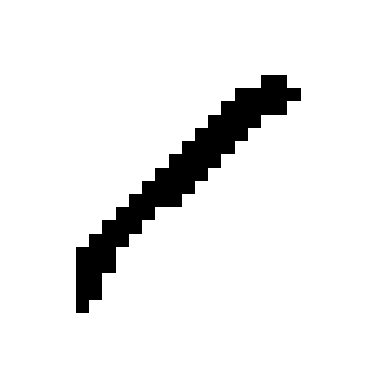

index: 460
/


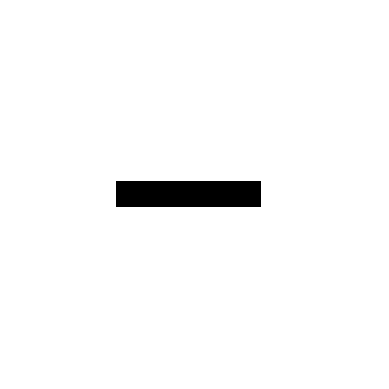

index: 468
/


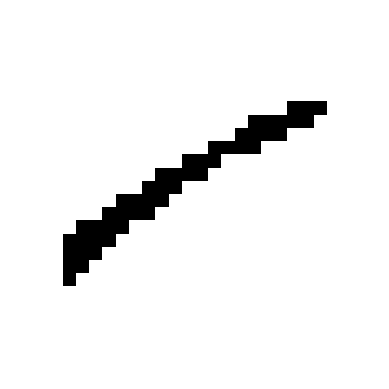

index: 517
-


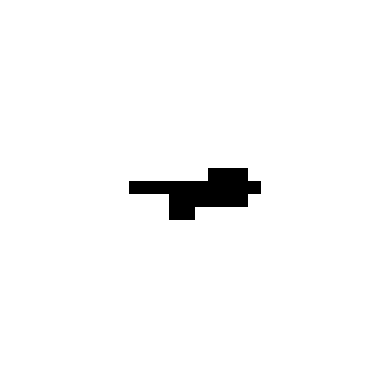

index: 550
=


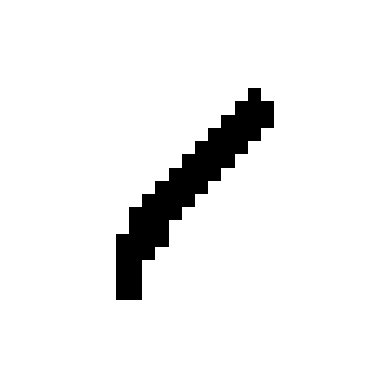

index: 571
-


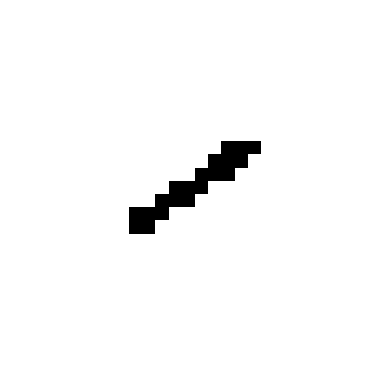

index: 574
/


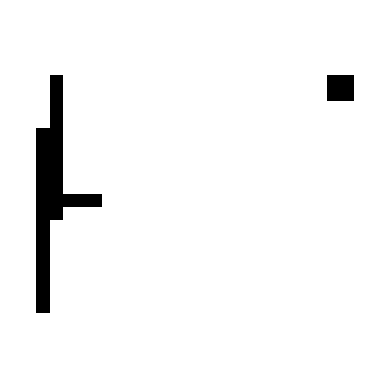

index: 583
+


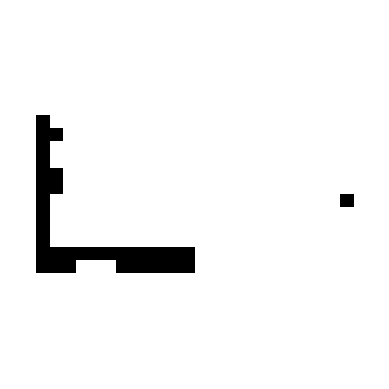

index: 586
+


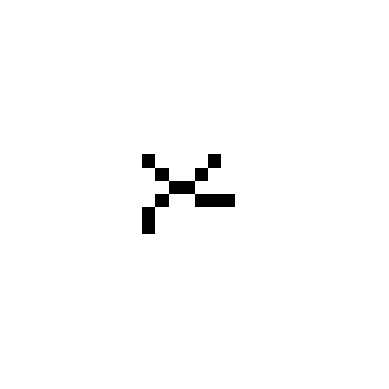

index: 600
x


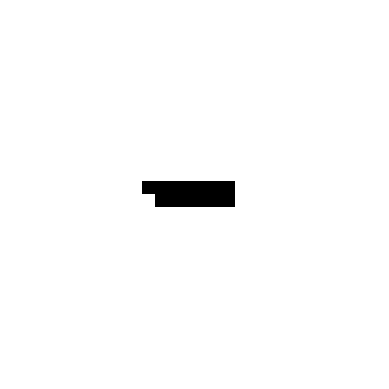

index: 604
-


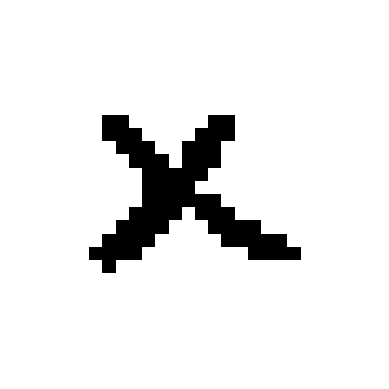

index: 651
=


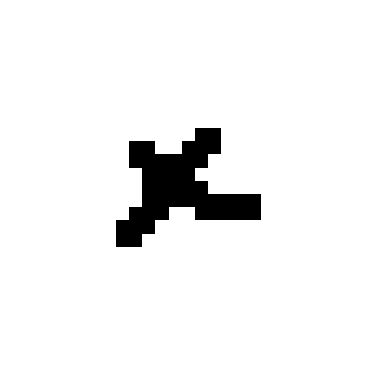

index: 684
x


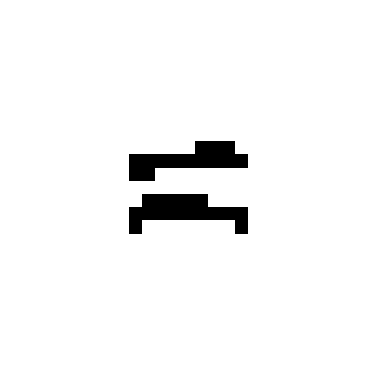

index: 694
=


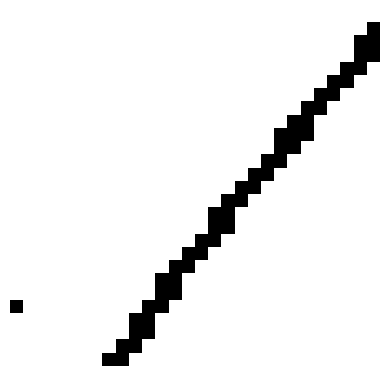

index: 738
/


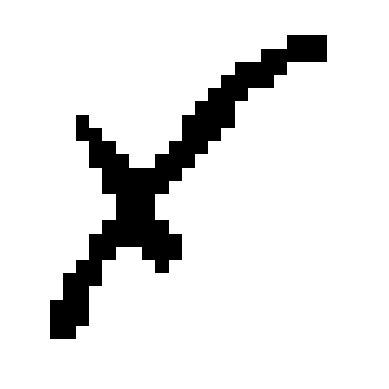

index: 742
x


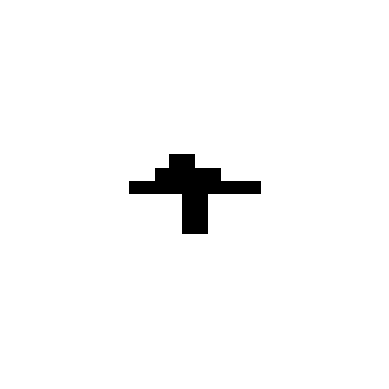

index: 791
-


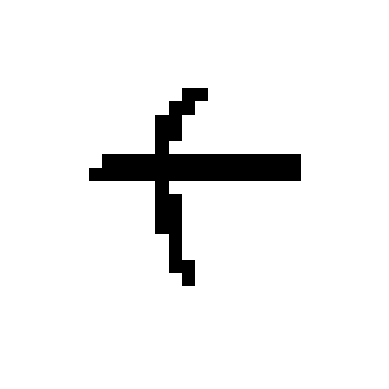

index: 799
+


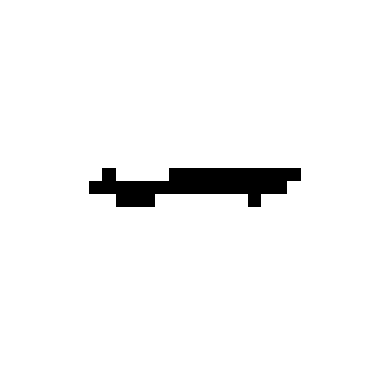

index: 802
=


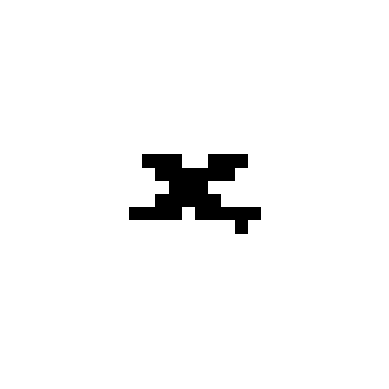

index: 813
-


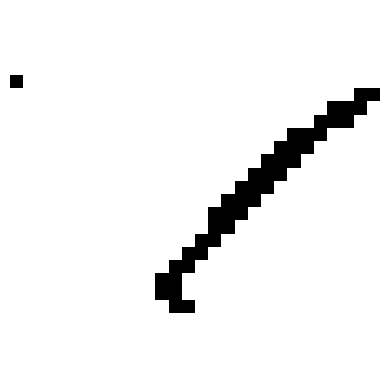

index: 871
/


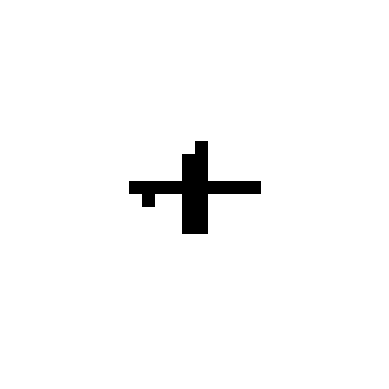

index: 892
+


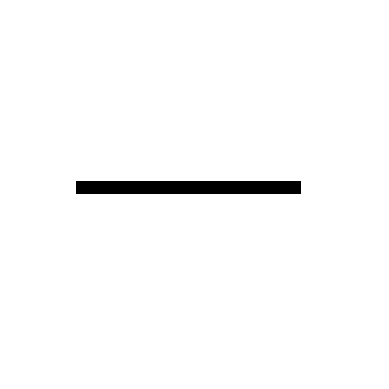

index: 971
x


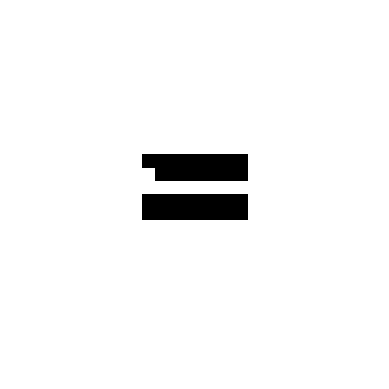

index: 976
+


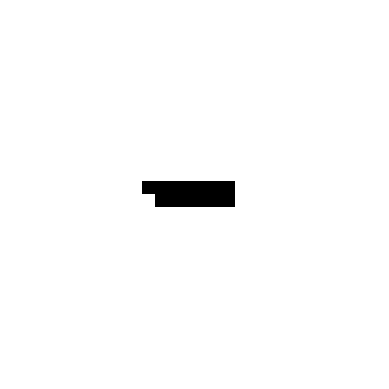

index: 985
-


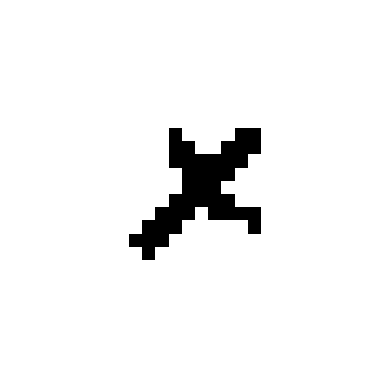

index: 1019
/


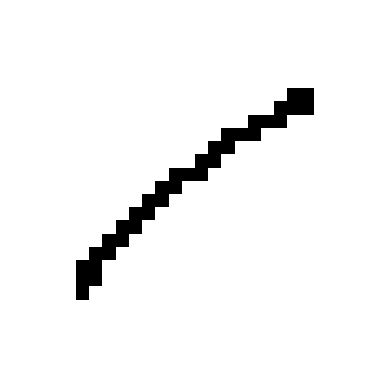

index: 1021
/


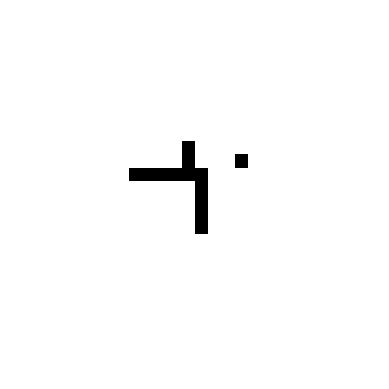

index: 1023
+


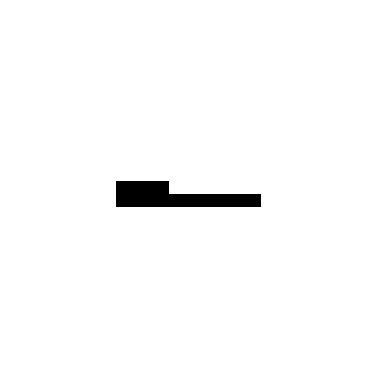

index: 1025
x


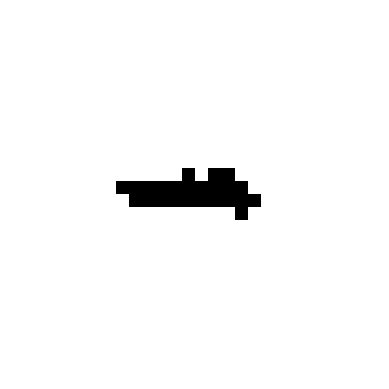

index: 1052
=


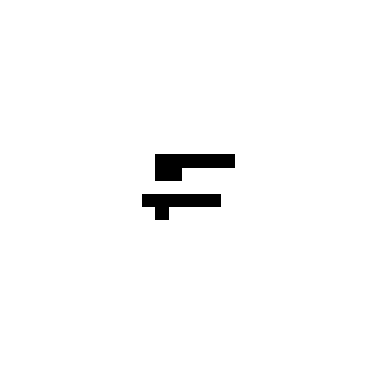

index: 1053
=


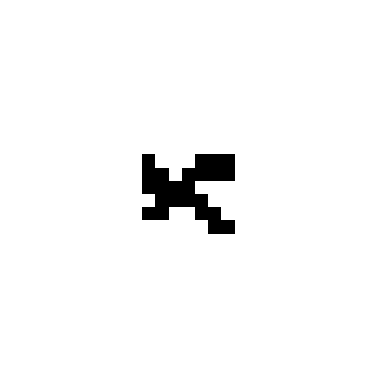

index: 1081
x


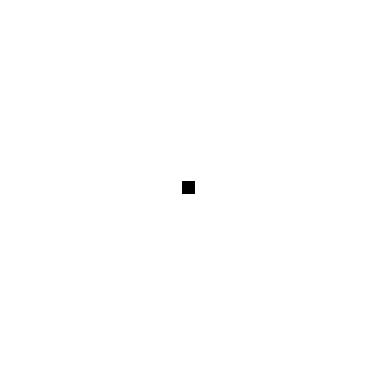

index: 1093
-


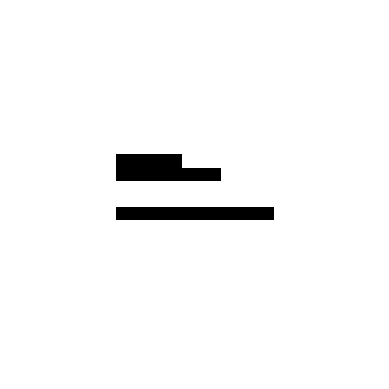

index: 1105
=


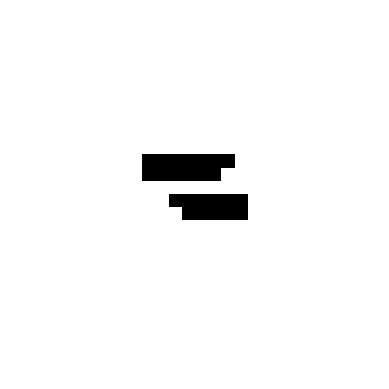

index: 1116
=


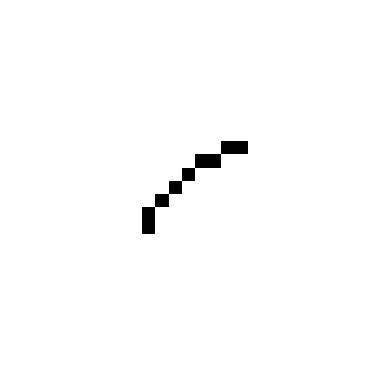

index: 1138
/


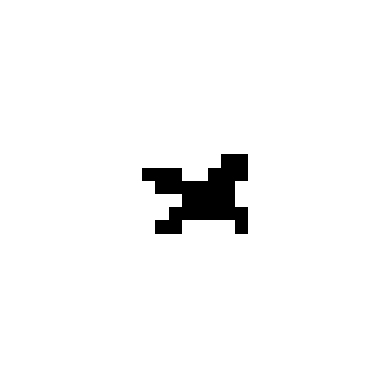

index: 1142
+


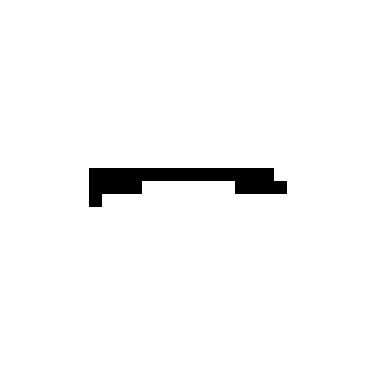

index: 1165
-


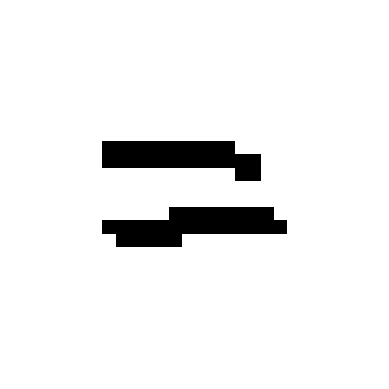

index: 1187
+


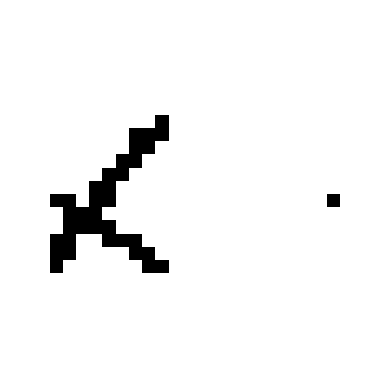

index: 1196
x


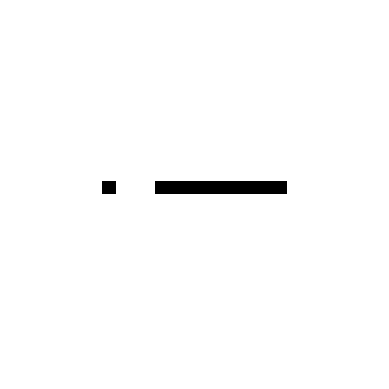

index: 1200
-


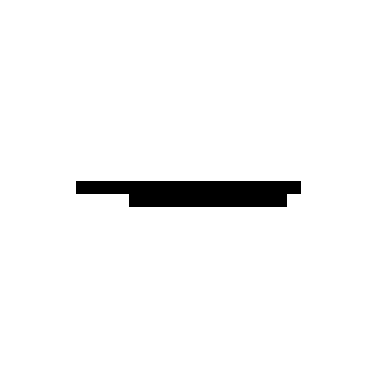

index: 1295
x


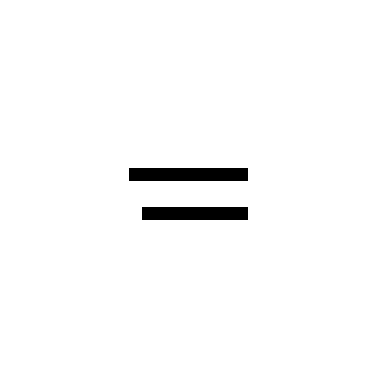

index: 1297
+


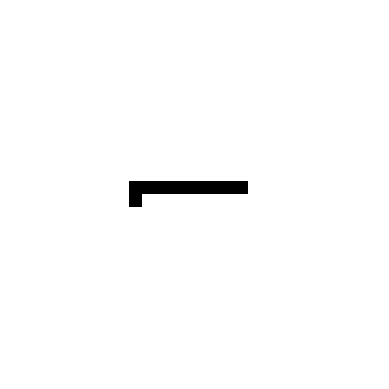

index: 1306
-


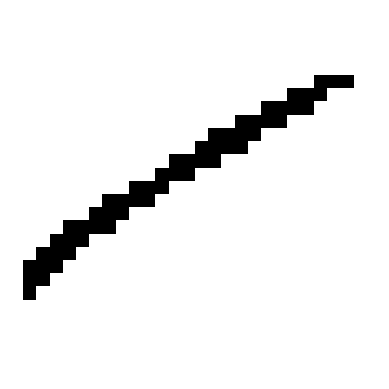

index: 1312
-


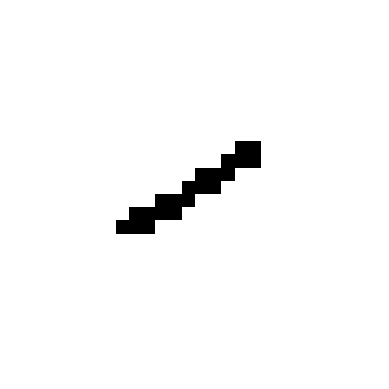

index: 1313
/


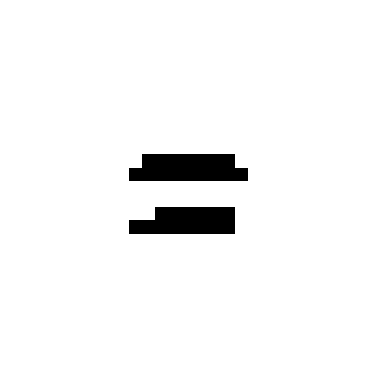

index: 1317
+


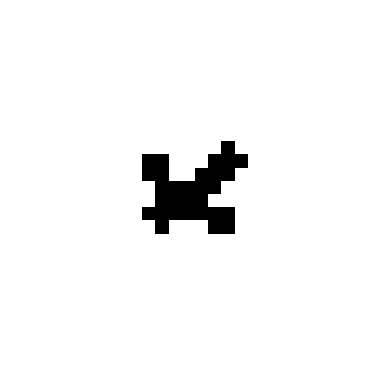

index: 1337
/


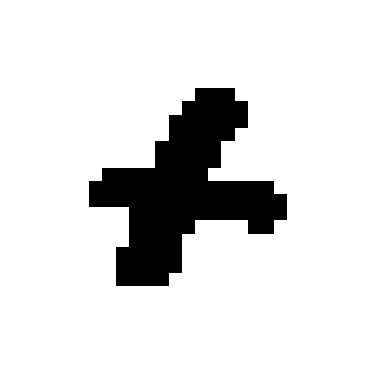

index: 1339
+


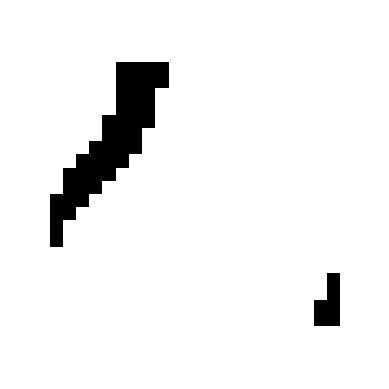

index: 1377
/


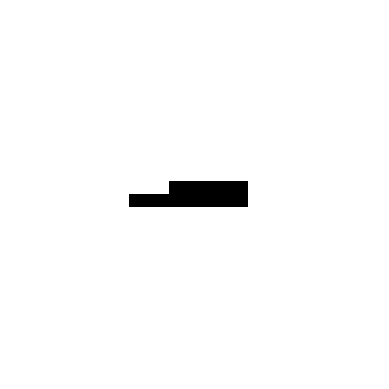

index: 1383
-


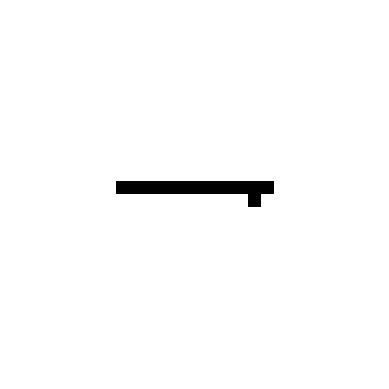

index: 1386
x


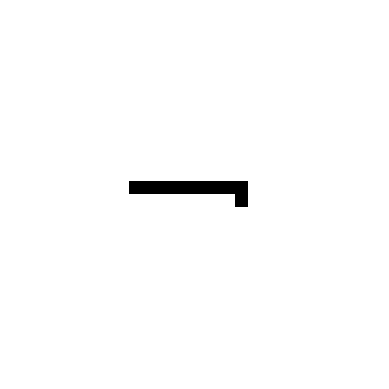

index: 1393
x


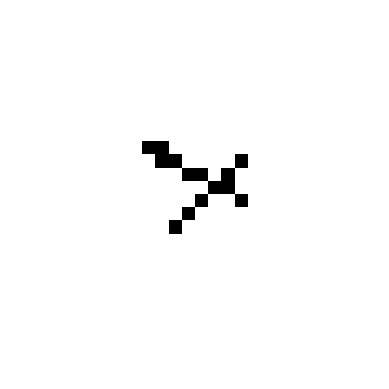

index: 1425
x


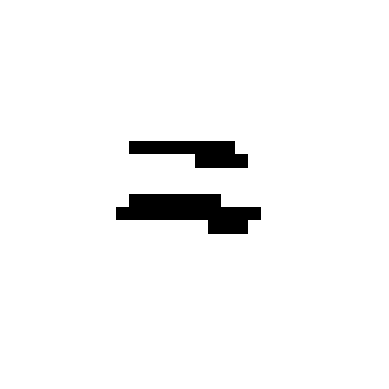

index: 1428
=


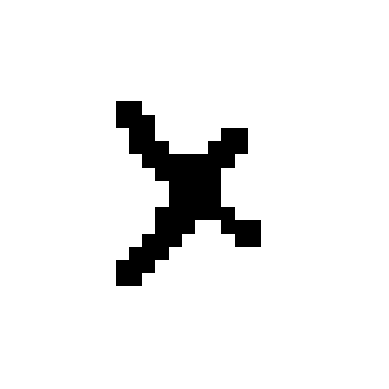

index: 1430
-


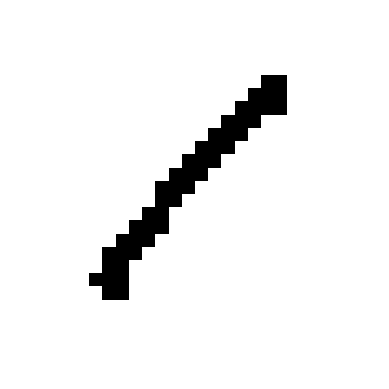

index: 1434
-


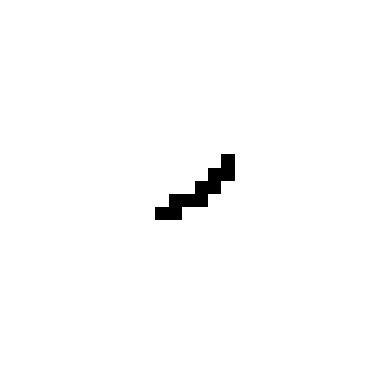

index: 1448
/


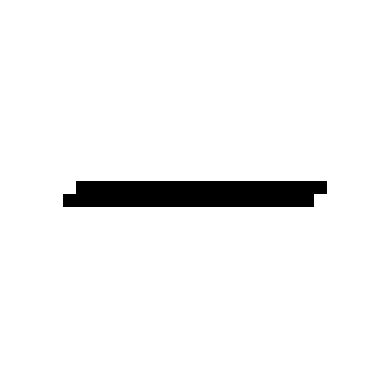

index: 1466
/


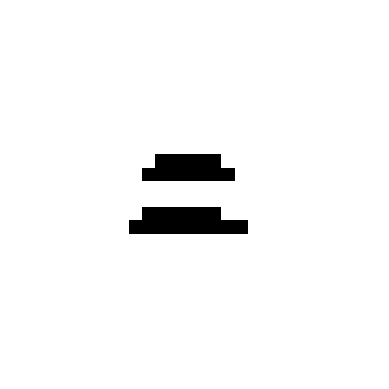

index: 1470
/


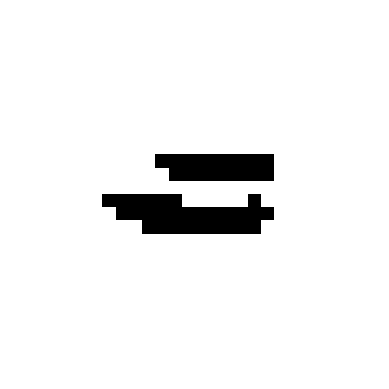

index: 1493
-


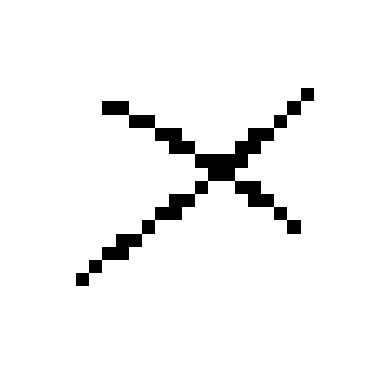

index: 1497
x


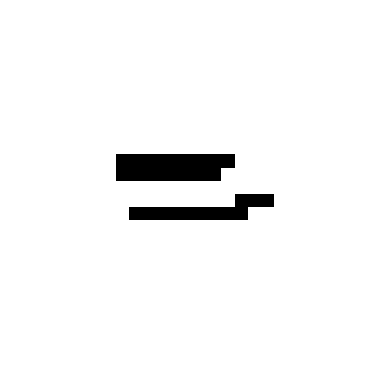

index: 1516
-


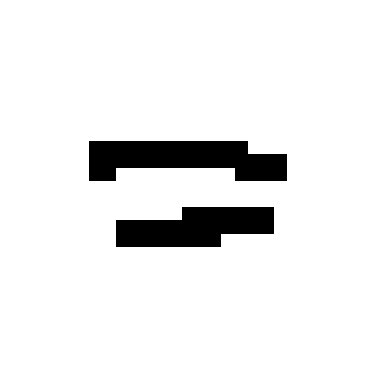

index: 1531
x


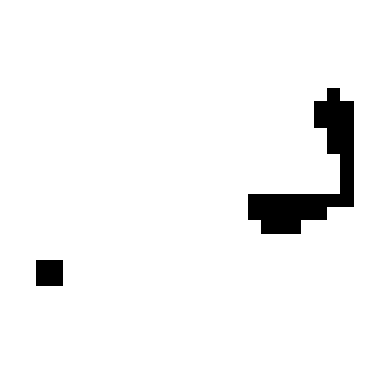

index: 1554
+


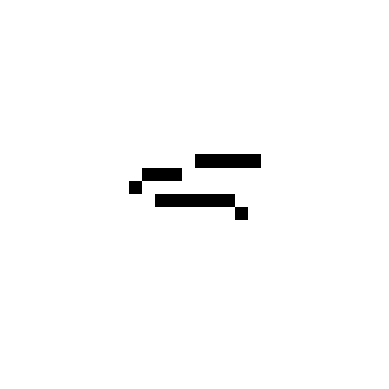

index: 1556
=


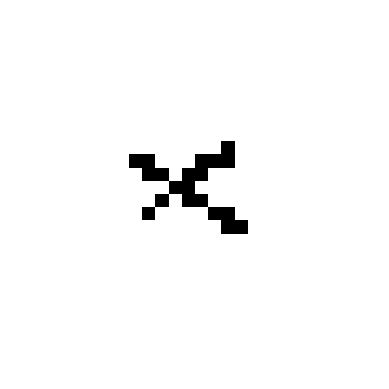

index: 1561
x


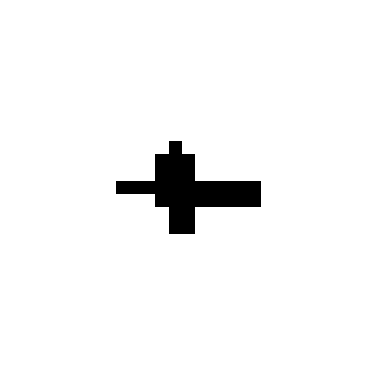

index: 1590
=


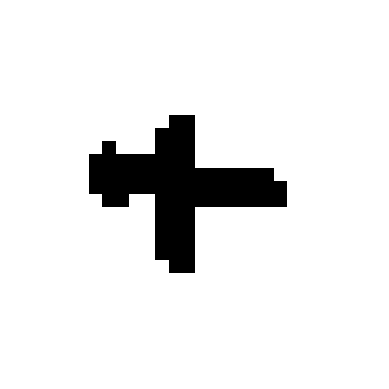

index: 1613
+


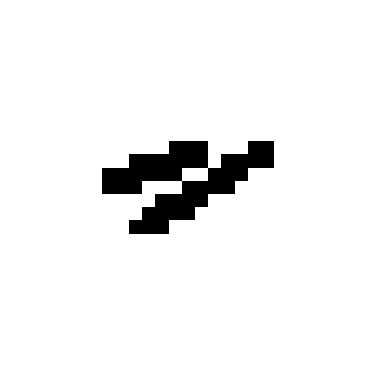

index: 1623
=


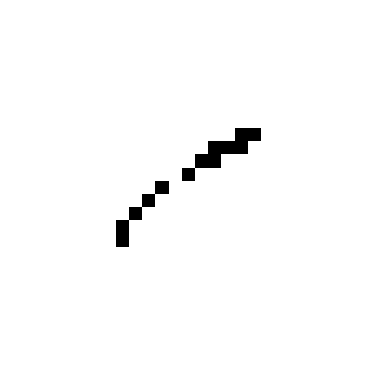

index: 1628
x


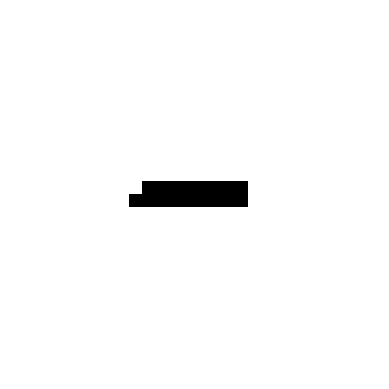

index: 1631
-


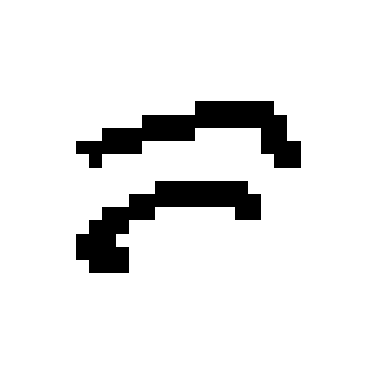

index: 1710
=


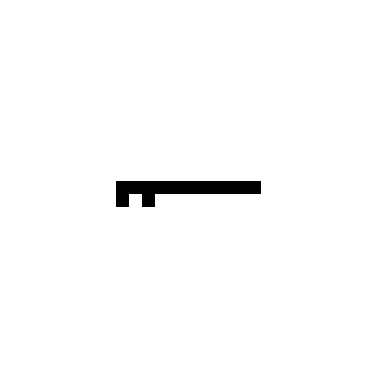

index: 1718
-


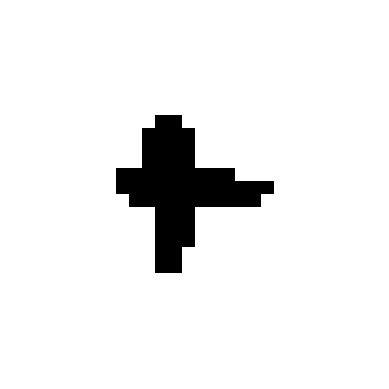

index: 1746
+


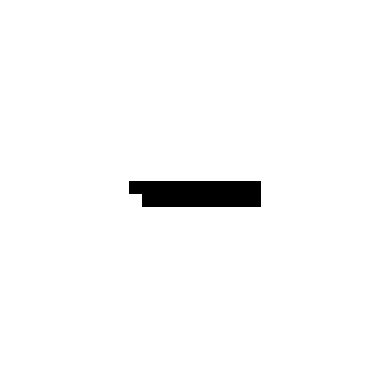

index: 1753
/


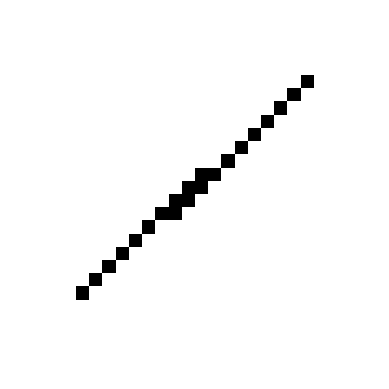

index: 1763
/


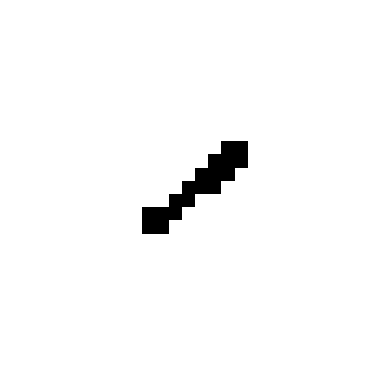

index: 1777
+


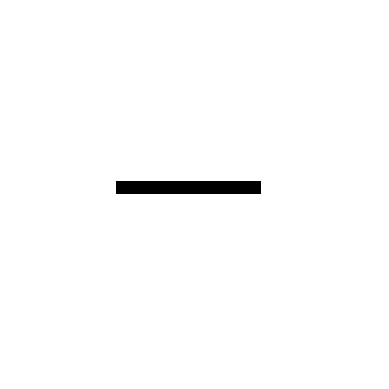

index: 1796
x


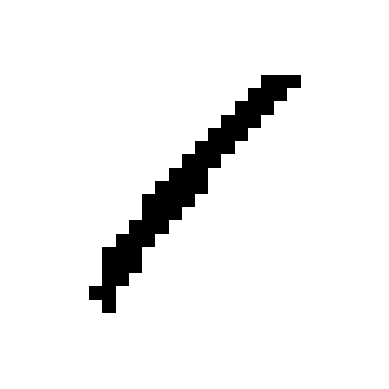

index: 1813
/


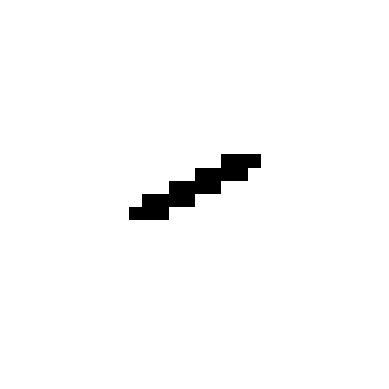

index: 1851
/


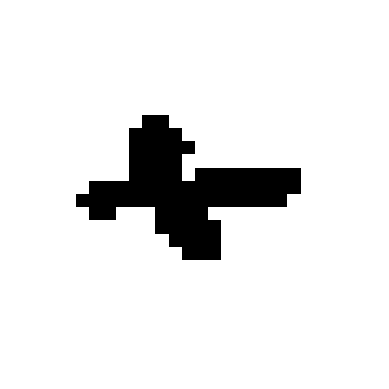

index: 1857
+


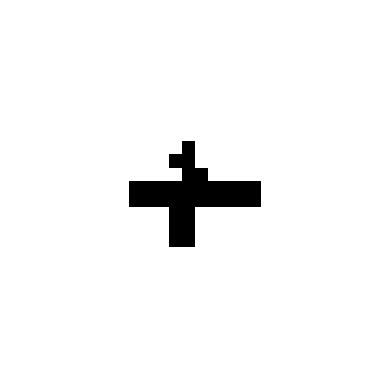

index: 1876
=


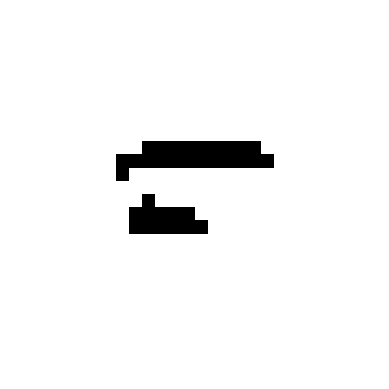

index: 1885
/


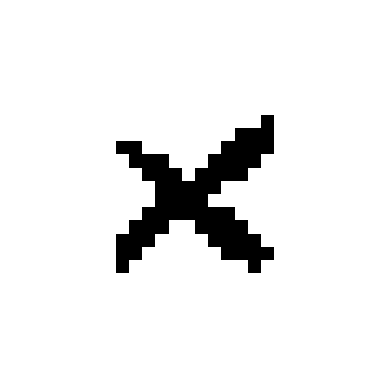

index: 1888
-


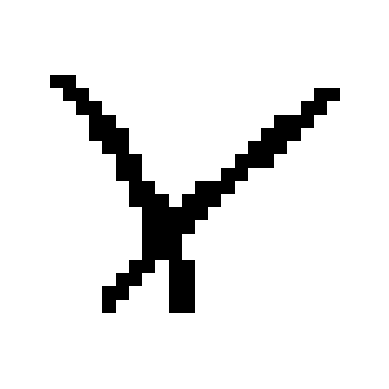

index: 1892
x


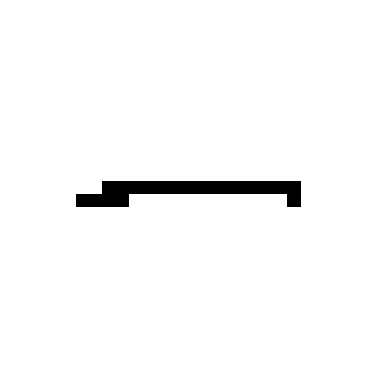

index: 1919
-


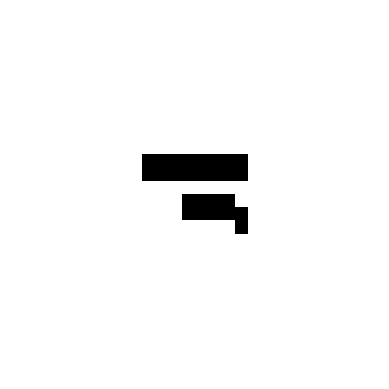

index: 1937
=


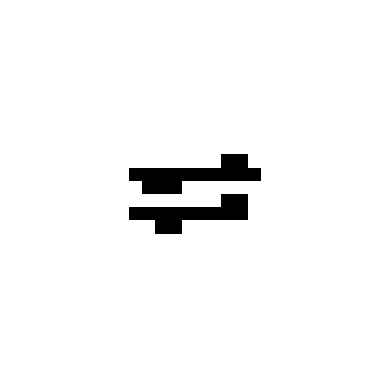

index: 1950
/


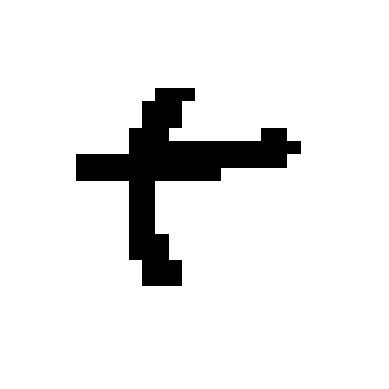

index: 1953
x


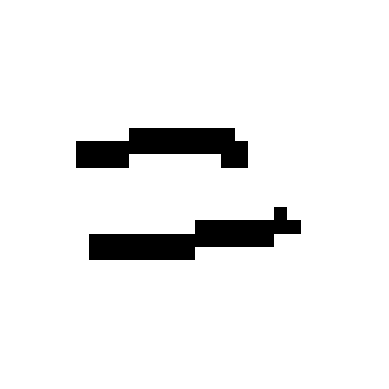

index: 1985
=


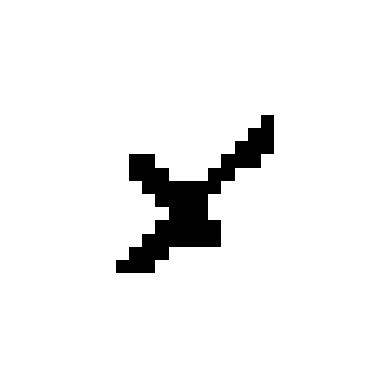

index: 1987
+


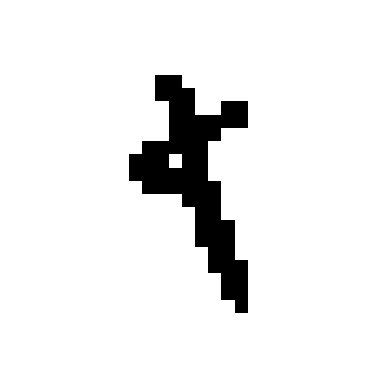

index: 2001
+


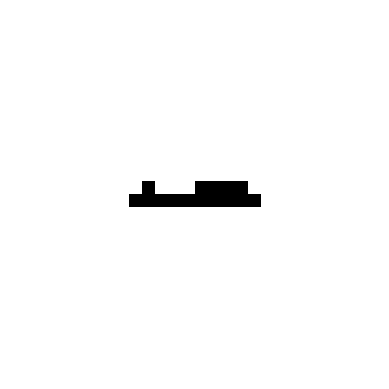

index: 2017
-


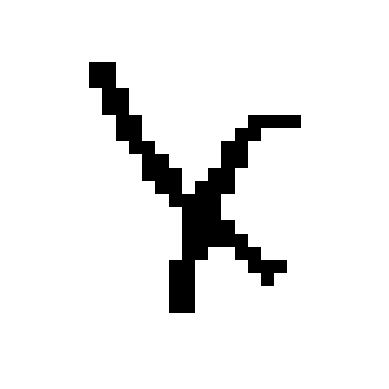

index: 2025
x


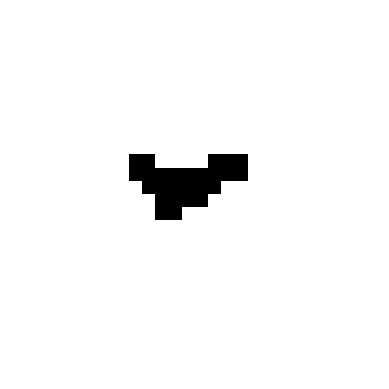

index: 2034
x


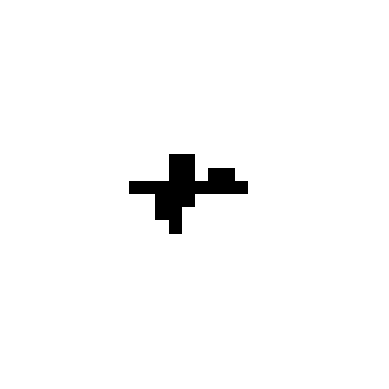

index: 2063
+


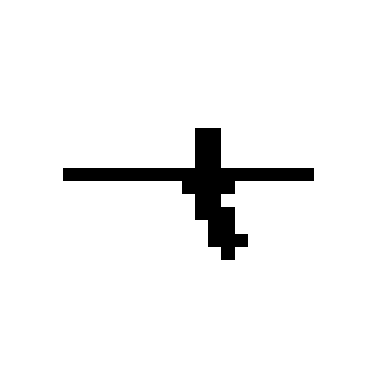

index: 2094
x


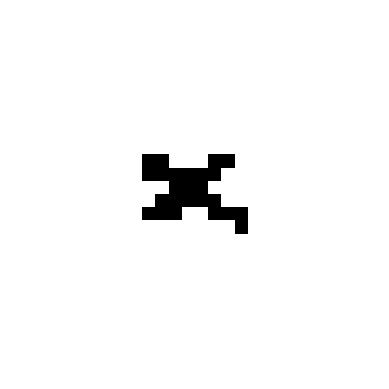

index: 2103
x


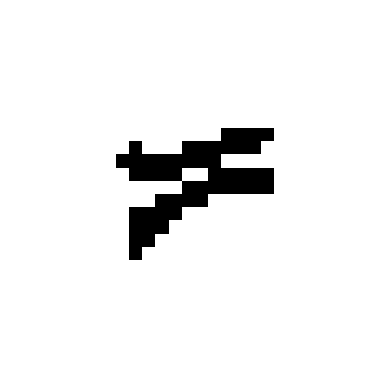

index: 2105
=


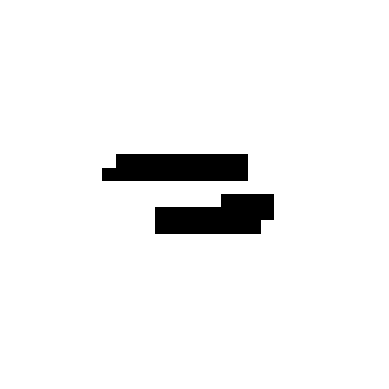

index: 2112
/


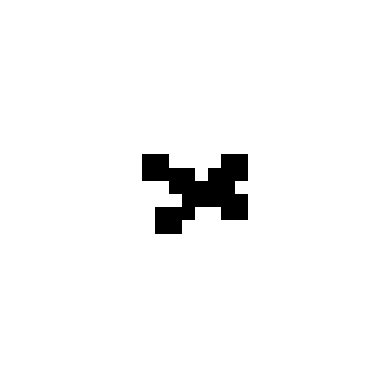

index: 2123
/


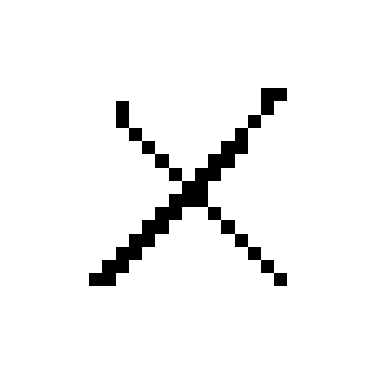

index: 2146
=


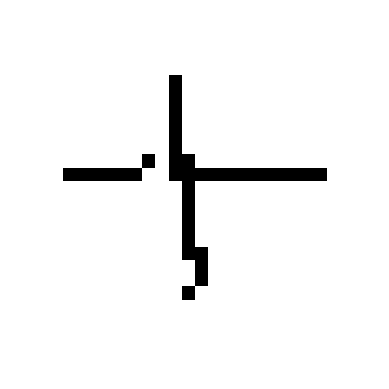

index: 2158
=


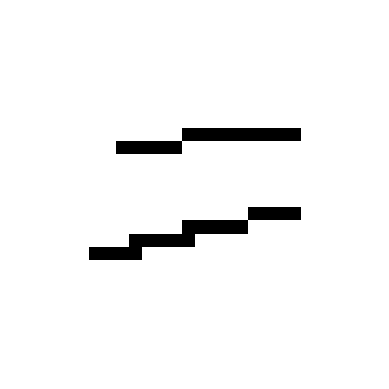

index: 2159
/


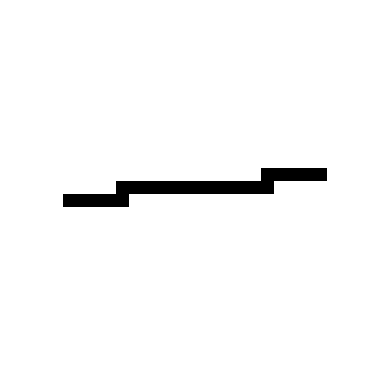

index: 2178
/


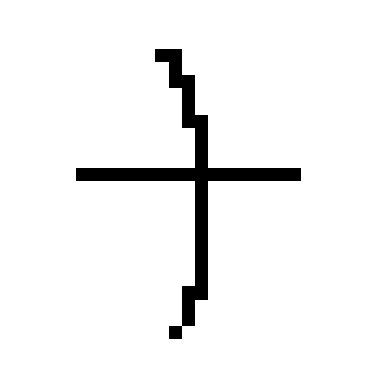

index: 2182
=


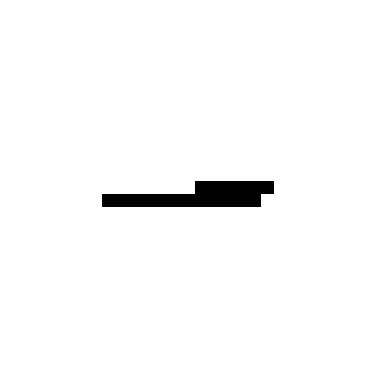

index: 2188
x


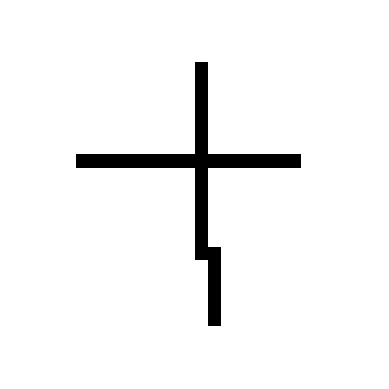

index: 2190
=


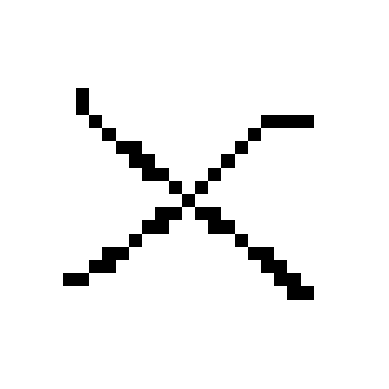

index: 2205
/


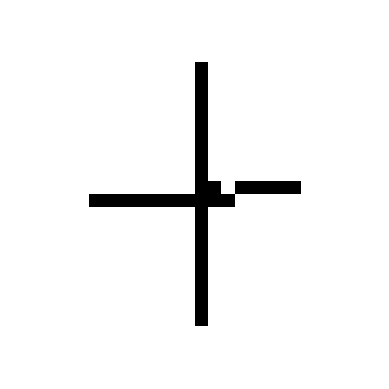

index: 2210
x


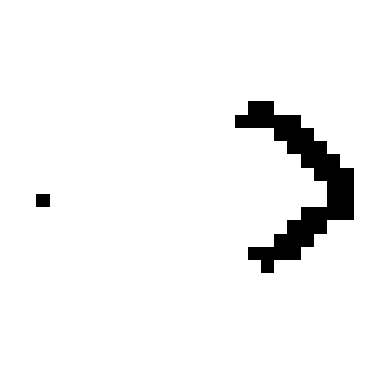

index: 2216
x


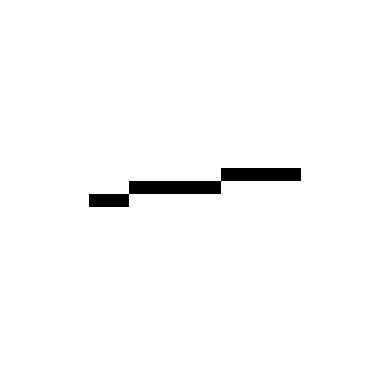

index: 2217
+


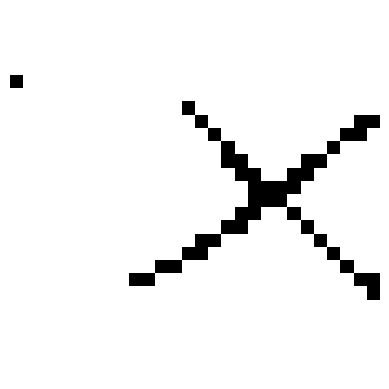

index: 2232
/


In [49]:
for i in list_ours.astype("int64"):
    plot_digit(sym_test_img_fixed[i])
    plt.show()
    print(f"index: {i}")
    print(sym_test_label_fixed[i])

In [50]:
# 1. fix label

toX = [17,246,396,651,813,1019,1142,1337,1430,1888,1987,2123,2146,2205,2232]
toPlus = [37,273,451,791,1590,1876,1953,2094,2158,2182,2190,2210]
toMin = [173,183,402,448,468,517,550,571,802,971,1025,1052,1295,1386,1393,1753,1796,2178,2188,2217]
toDiv = [90,164,291,1312,1434,1466,1628,1777]
toEqu = [356,366,976,1187,1297,1317,1470,1493,1516,1532,1885,1950,2112,2159]

for i in toX:
    sym_test_label_fixed[i] = 'x'

for i in toPlus:
    sym_test_label_fixed[i] = '+'

for i in toMin:
    sym_test_label_fixed[i] = '-'

for i in toDiv:
    sym_test_label_fixed[i] = '/'

for i in toEqu:
    sym_test_label_fixed[i] = '='

# 2. delete label and img

# 61, 292, 583, 586, 1093, 1377, 1554, 2001, 2034, 2216

sym_test_label_fixed = np.delete(sym_test_label_fixed, (61, 292, 583, 586, 1093, 1377, 1554, 2001, 2034, 2216))
sym_test_img_fixed = np.delete(sym_test_img_fixed, (61, 292, 583, 586, 1093, 1377, 1554, 2001, 2034, 2216), axis=0)

In [51]:
print(
    sym_test_label_fixed.shape,
    sym_test_img_fixed.shape
)

(2228,) (2228, 28, 28)


## save

In [53]:
np.savez_compressed(path / 'digit_data_10_Test_relabeled.npz', img=num_test_img_fixed, label=num_test_label_fixed)
np.savez_compressed(path / 'digit_data_TrVal_relabeled.npz', img=num_trVal_img_fixed, label=num_trVal_label_fixed)
np.savez_compressed(path / 'op_data_10_Test_relabeled.npz', img=sym_test_img_fixed, label=sym_test_label_fixed)
np.savez_compressed(path / 'op_data_TrVal_relabeled.npz', img=sym_trVal_img_fixed, label=sym_trVal_label_fixed)

In [54]:
curr_data_sym_trVal.close()
curr_data_num_test.close()
curr_data_num_trVal.close()
curr_data_sym_test.close()